In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(540704, 828)
(540704, 1)
validation
(80437, 828)
(80437, 1)
test
(63506, 828)
(63506, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/55 [..............................] - ETA: 1:26 - loss: 0.2745 - STD: 1.3161e-04 - MAE: 0.5133

 4/55 [=>............................] - ETA: 1s - loss: 0.0999 - STD: 3.9402e-04 - MAE: 0.2514  

 5/55 [=>............................] - ETA: 2s - loss: 0.0834 - STD: 3.4579e-04 - MAE: 0.2201

 6/55 [==>...........................] - ETA: 2s - loss: 0.0734 - STD: 3.0099e-04 - MAE: 0.2029

 7/55 [==>...........................] - ETA: 2s - loss: 0.0668 - STD: 2.6373e-04 - MAE: 0.1925

 8/55 [===>..........................] - ETA: 2s - loss: 0.0622 - STD: 2.3337e-04 - MAE: 0.1858

 9/55 [===>..........................] - ETA: 2s - loss: 0.0588 - STD: 2.0855e-04 - MAE: 0.1812

10/55 [====>.........................] - ETA: 2s - loss: 0.0562 - STD: 1.8811e-04 - MAE: 0.1779

11/55 [=====>........................] - ETA: 2s - loss: 0.0541 - STD: 1.7142e-04 - MAE: 0.1753

12/55 [=====>........................] - ETA: 2s - loss: 0.0523 - STD: 1.5772e-04 - MAE: 0.1731

13/55 [======>.......................] - ETA: 2s - loss: 0.0508 - STD: 1.4630e-04 - MAE: 0.1713

14/55 [======>.......................] - ETA: 2s - loss: 0.0496 - STD: 1.3662e-04 - MAE: 0.1697

15/55 [=======>......................] - ETA: 2s - loss: 0.0484 - STD: 1.2829e-04 - MAE: 0.1682

16/55 [=======>......................] - ETA: 2s - loss: 0.0474 - STD: 1.2108e-04 - MAE: 0.1668

17/55 [========>.....................] - ETA: 2s - loss: 0.0464 - STD: 1.1474e-04 - MAE: 0.1653

18/55 [========>.....................] - ETA: 2s - loss: 0.0455 - STD: 1.0915e-04 - MAE: 0.1638

19/55 [=========>....................] - ETA: 2s - loss: 0.0446 - STD: 1.0419e-04 - MAE: 0.1622

20/55 [=========>....................] - ETA: 2s - loss: 0.0437 - STD: 9.9770e-05 - MAE: 0.1605

21/55 [==========>...................] - ETA: 2s - loss: 0.0428 - STD: 9.5835e-05 - MAE: 0.1586

22/55 [===========>..................] - ETA: 2s - loss: 0.0419 - STD: 9.2288e-05 - MAE: 0.1566

23/55 [===========>..................] - ETA: 2s - loss: 0.0410 - STD: 8.9088e-05 - MAE: 0.1544

24/55 [============>.................] - ETA: 1s - loss: 0.0400 - STD: 8.6218e-05 - MAE: 0.1520

25/55 [============>.................] - ETA: 1s - loss: 0.0391 - STD: 8.3611e-05 - MAE: 0.1496

26/55 [=============>................] - ETA: 1s - loss: 0.0381 - STD: 8.1224e-05 - MAE: 0.1471

27/55 [=============>................] - ETA: 1s - loss: 0.0372 - STD: 7.9040e-05 - MAE: 0.1447

28/55 [==============>...............] - ETA: 1s - loss: 0.0363 - STD: 7.7031e-05 - MAE: 0.1424

29/55 [==============>...............] - ETA: 1s - loss: 0.0354 - STD: 7.5174e-05 - MAE: 0.1403

30/55 [===============>..............] - ETA: 1s - loss: 0.0346 - STD: 7.3406e-05 - MAE: 0.1384

31/55 [===============>..............] - ETA: 1s - loss: 0.0339 - STD: 7.1726e-05 - MAE: 0.1368

32/55 [================>.............] - ETA: 1s - loss: 0.0332 - STD: 7.0114e-05 - MAE: 0.1355

33/55 [=================>............] - ETA: 1s - loss: 0.0326 - STD: 6.8558e-05 - MAE: 0.1344

34/55 [=================>............] - ETA: 1s - loss: 0.0320 - STD: 6.7061e-05 - MAE: 0.1334

35/55 [==================>...........] - ETA: 1s - loss: 0.0315 - STD: 6.5599e-05 - MAE: 0.1324

36/55 [==================>...........] - ETA: 1s - loss: 0.0310 - STD: 6.4191e-05 - MAE: 0.1315

37/55 [===================>..........] - ETA: 1s - loss: 0.0305 - STD: 6.2824e-05 - MAE: 0.1306

38/55 [===================>..........] - ETA: 1s - loss: 0.0301 - STD: 6.1502e-05 - MAE: 0.1297

39/55 [====================>.........] - ETA: 1s - loss: 0.0296 - STD: 6.0217e-05 - MAE: 0.1287

40/55 [====================>.........] - ETA: 0s - loss: 0.0292 - STD: 5.8975e-05 - MAE: 0.1276

41/55 [=====================>........] - ETA: 0s - loss: 0.0287 - STD: 5.7764e-05 - MAE: 0.1266

42/55 [=====================>........] - ETA: 0s - loss: 0.0283 - STD: 5.6592e-05 - MAE: 0.1256

43/55 [======================>.......] - ETA: 0s - loss: 0.0279 - STD: 5.5461e-05 - MAE: 0.1245

44/55 [=======================>......] - ETA: 0s - loss: 0.0279 - STD: 5.4368e-05 - MAE: 0.1235

47/55 [========================>.....] - ETA: 0s - loss: 0.0268 - STD: 5.1322e-05 - MAE: 0.1207

49/55 [=========================>....] - ETA: 0s - loss: 0.0262 - STD: 4.9479e-05 - MAE: 0.1191

50/55 [==========================>...] - ETA: 0s - loss: 0.0259 - STD: 4.8612e-05 - MAE: 0.1183

51/55 [==========================>...] - ETA: 0s - loss: 0.0256 - STD: 4.7781e-05 - MAE: 0.1175

52/55 [===========================>..] - ETA: 0s - loss: 0.0253 - STD: 4.6980e-05 - MAE: 0.1168

53/55 [===========================>..] - ETA: 0s - loss: 0.0251 - STD: 4.6212e-05 - MAE: 0.1161

54/55 [============================>.] - ETA: 0s - loss: 0.0248 - STD: 4.5475e-05 - MAE: 0.1154

55/55 [==============================] - ETA: 0s - loss: 0.0245 - STD: 4.4766e-05 - MAE: 0.1148

55/55 [==============================] - 6s 85ms/step - loss: 0.0245 - STD: 4.4766e-05 - MAE: 0.1148 - val_loss: 0.0122 - val_STD: 6.2794e-06 - val_MAE: 0.0845


Epoch 2/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0109 - STD: 6.4747e-06 - MAE: 0.0802

 2/55 [>.............................] - ETA: 4s - loss: 0.0108 - STD: 6.5022e-06 - MAE: 0.0810

 3/55 [>.............................] - ETA: 3s - loss: 0.0109 - STD: 6.5711e-06 - MAE: 0.0815

 4/55 [=>............................] - ETA: 3s - loss: 0.0109 - STD: 6.5899e-06 - MAE: 0.0820

 5/55 [=>............................] - ETA: 3s - loss: 0.0110 - STD: 6.6109e-06 - MAE: 0.0824

 6/55 [==>...........................] - ETA: 3s - loss: 0.0110 - STD: 6.6226e-06 - MAE: 0.0829

 7/55 [==>...........................] - ETA: 3s - loss: 0.0111 - STD: 6.6333e-06 - MAE: 0.0832

 8/55 [===>..........................] - ETA: 3s - loss: 0.0111 - STD: 6.6480e-06 - MAE: 0.0835

 9/55 [===>..........................] - ETA: 3s - loss: 0.0111 - STD: 6.6442e-06 - MAE: 0.0836

10/55 [====>.........................] - ETA: 3s - loss: 0.0111 - STD: 6.6451e-06 - MAE: 0.0837

11/55 [=====>........................] - ETA: 3s - loss: 0.0111 - STD: 6.6401e-06 - MAE: 0.0837

12/55 [=====>........................] - ETA: 3s - loss: 0.0111 - STD: 6.6332e-06 - MAE: 0.0838

13/55 [======>.......................] - ETA: 3s - loss: 0.0111 - STD: 6.6211e-06 - MAE: 0.0837

14/55 [======>.......................] - ETA: 3s - loss: 0.0111 - STD: 6.6168e-06 - MAE: 0.0836

15/55 [=======>......................] - ETA: 2s - loss: 0.0111 - STD: 6.6121e-06 - MAE: 0.0835

16/55 [=======>......................] - ETA: 2s - loss: 0.0111 - STD: 6.6067e-06 - MAE: 0.0833

17/55 [========>.....................] - ETA: 2s - loss: 0.0111 - STD: 6.6092e-06 - MAE: 0.0832

18/55 [========>.....................] - ETA: 2s - loss: 0.0111 - STD: 6.6028e-06 - MAE: 0.0831

19/55 [=========>....................] - ETA: 2s - loss: 0.0111 - STD: 6.6020e-06 - MAE: 0.0829

20/55 [=========>....................] - ETA: 2s - loss: 0.0111 - STD: 6.6047e-06 - MAE: 0.0828

21/55 [==========>...................] - ETA: 2s - loss: 0.0111 - STD: 6.6071e-06 - MAE: 0.0827

22/55 [===========>..................] - ETA: 2s - loss: 0.0111 - STD: 6.6137e-06 - MAE: 0.0826

23/55 [===========>..................] - ETA: 2s - loss: 0.0111 - STD: 6.6212e-06 - MAE: 0.0825

24/55 [============>.................] - ETA: 2s - loss: 0.0111 - STD: 6.6292e-06 - MAE: 0.0824

25/55 [============>.................] - ETA: 2s - loss: 0.0111 - STD: 6.6432e-06 - MAE: 0.0824

26/55 [=============>................] - ETA: 2s - loss: 0.0111 - STD: 6.6566e-06 - MAE: 0.0824

27/55 [=============>................] - ETA: 1s - loss: 0.0111 - STD: 6.6740e-06 - MAE: 0.0823

28/55 [==============>...............] - ETA: 1s - loss: 0.0111 - STD: 6.6891e-06 - MAE: 0.0823

29/55 [==============>...............] - ETA: 1s - loss: 0.0111 - STD: 6.7103e-06 - MAE: 0.0823

30/55 [===============>..............] - ETA: 1s - loss: 0.0111 - STD: 6.7332e-06 - MAE: 0.0823

31/55 [===============>..............] - ETA: 1s - loss: 0.0111 - STD: 6.7571e-06 - MAE: 0.0823

32/55 [================>.............] - ETA: 1s - loss: 0.0111 - STD: 6.7808e-06 - MAE: 0.0824

33/55 [=================>............] - ETA: 1s - loss: 0.0111 - STD: 6.8089e-06 - MAE: 0.0824

34/55 [=================>............] - ETA: 1s - loss: 0.0111 - STD: 6.8332e-06 - MAE: 0.0824

35/55 [==================>...........] - ETA: 1s - loss: 0.0111 - STD: 6.8589e-06 - MAE: 0.0824

36/55 [==================>...........] - ETA: 1s - loss: 0.0111 - STD: 6.8852e-06 - MAE: 0.0824

37/55 [===================>..........] - ETA: 1s - loss: 0.0111 - STD: 6.9092e-06 - MAE: 0.0824

38/55 [===================>..........] - ETA: 1s - loss: 0.0111 - STD: 6.9364e-06 - MAE: 0.0824

39/55 [====================>.........] - ETA: 1s - loss: 0.0111 - STD: 6.9639e-06 - MAE: 0.0824

40/55 [====================>.........] - ETA: 1s - loss: 0.0111 - STD: 6.9934e-06 - MAE: 0.0823

42/55 [=====================>........] - ETA: 0s - loss: 0.0111 - STD: 7.0497e-06 - MAE: 0.0824

43/55 [======================>.......] - ETA: 0s - loss: 0.0111 - STD: 7.0794e-06 - MAE: 0.0823

44/55 [=======================>......] - ETA: 0s - loss: 0.0111 - STD: 7.1120e-06 - MAE: 0.0823

45/55 [=======================>......] - ETA: 0s - loss: 0.0111 - STD: 7.1429e-06 - MAE: 0.0823

46/55 [========================>.....] - ETA: 0s - loss: 0.0111 - STD: 7.1767e-06 - MAE: 0.0823

47/55 [========================>.....] - ETA: 0s - loss: 0.0111 - STD: 7.2118e-06 - MAE: 0.0823

48/55 [=========================>....] - ETA: 0s - loss: 0.0111 - STD: 7.2456e-06 - MAE: 0.0823

49/55 [=========================>....] - ETA: 0s - loss: 0.0111 - STD: 7.2809e-06 - MAE: 0.0823

50/55 [==========================>...] - ETA: 0s - loss: 0.0111 - STD: 7.3188e-06 - MAE: 0.0823

51/55 [==========================>...] - ETA: 0s - loss: 0.0111 - STD: 7.3563e-06 - MAE: 0.0823

52/55 [===========================>..] - ETA: 0s - loss: 0.0111 - STD: 7.3933e-06 - MAE: 0.0823

53/55 [===========================>..] - ETA: 0s - loss: 0.0111 - STD: 7.4305e-06 - MAE: 0.0823

54/55 [============================>.] - ETA: 0s - loss: 0.0111 - STD: 7.4685e-06 - MAE: 0.0823

55/55 [==============================] - ETA: 0s - loss: 0.0111 - STD: 7.5090e-06 - MAE: 0.0823

55/55 [==============================] - 4s 73ms/step - loss: 0.0111 - STD: 7.5090e-06 - MAE: 0.0823 - val_loss: 0.0121 - val_STD: 9.3226e-06 - val_MAE: 0.0855


Epoch 3/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0110 - STD: 9.7879e-06 - MAE: 0.0822

 2/55 [>.............................] - ETA: 3s - loss: 0.0109 - STD: 9.8583e-06 - MAE: 0.0815

 3/55 [>.............................] - ETA: 3s - loss: 0.0109 - STD: 9.8882e-06 - MAE: 0.0815

 4/55 [=>............................] - ETA: 3s - loss: 0.0109 - STD: 9.9664e-06 - MAE: 0.0817

 5/55 [=>............................] - ETA: 3s - loss: 0.0109 - STD: 1.0023e-05 - MAE: 0.0818

 6/55 [==>...........................] - ETA: 3s - loss: 0.0110 - STD: 1.0113e-05 - MAE: 0.0821

 7/55 [==>...........................] - ETA: 3s - loss: 0.0110 - STD: 1.0182e-05 - MAE: 0.0822

 8/55 [===>..........................] - ETA: 3s - loss: 0.0111 - STD: 1.0256e-05 - MAE: 0.0822

 9/55 [===>..........................] - ETA: 3s - loss: 0.0111 - STD: 1.0323e-05 - MAE: 0.0823

10/55 [====>.........................] - ETA: 3s - loss: 0.0111 - STD: 1.0385e-05 - MAE: 0.0823

11/55 [=====>........................] - ETA: 2s - loss: 0.0110 - STD: 1.0449e-05 - MAE: 0.0823

12/55 [=====>........................] - ETA: 2s - loss: 0.0111 - STD: 1.0518e-05 - MAE: 0.0823

13/55 [======>.......................] - ETA: 2s - loss: 0.0111 - STD: 1.0584e-05 - MAE: 0.0823

14/55 [======>.......................] - ETA: 2s - loss: 0.0110 - STD: 1.0651e-05 - MAE: 0.0822

15/55 [=======>......................] - ETA: 2s - loss: 0.0111 - STD: 1.0721e-05 - MAE: 0.0822

16/55 [=======>......................] - ETA: 2s - loss: 0.0110 - STD: 1.0792e-05 - MAE: 0.0822

17/55 [========>.....................] - ETA: 2s - loss: 0.0110 - STD: 1.0865e-05 - MAE: 0.0822

18/55 [========>.....................] - ETA: 2s - loss: 0.0110 - STD: 1.0938e-05 - MAE: 0.0821

19/55 [=========>....................] - ETA: 2s - loss: 0.0110 - STD: 1.1009e-05 - MAE: 0.0821

20/55 [=========>....................] - ETA: 2s - loss: 0.0110 - STD: 1.1085e-05 - MAE: 0.0821

21/55 [==========>...................] - ETA: 2s - loss: 0.0110 - STD: 1.1161e-05 - MAE: 0.0820

22/55 [===========>..................] - ETA: 2s - loss: 0.0110 - STD: 1.1240e-05 - MAE: 0.0820

23/55 [===========>..................] - ETA: 2s - loss: 0.0110 - STD: 1.1320e-05 - MAE: 0.0820

24/55 [============>.................] - ETA: 2s - loss: 0.0110 - STD: 1.1403e-05 - MAE: 0.0820

25/55 [============>.................] - ETA: 2s - loss: 0.0110 - STD: 1.1480e-05 - MAE: 0.0819

27/55 [=============>................] - ETA: 1s - loss: 0.0110 - STD: 1.1644e-05 - MAE: 0.0818

28/55 [==============>...............] - ETA: 1s - loss: 0.0110 - STD: 1.1728e-05 - MAE: 0.0818

29/55 [==============>...............] - ETA: 1s - loss: 0.0110 - STD: 1.1815e-05 - MAE: 0.0818

30/55 [===============>..............] - ETA: 1s - loss: 0.0110 - STD: 1.1900e-05 - MAE: 0.0819

31/55 [===============>..............] - ETA: 1s - loss: 0.0110 - STD: 1.1988e-05 - MAE: 0.0818

32/55 [================>.............] - ETA: 1s - loss: 0.0110 - STD: 1.2073e-05 - MAE: 0.0818

33/55 [=================>............] - ETA: 1s - loss: 0.0110 - STD: 1.2168e-05 - MAE: 0.0818

34/55 [=================>............] - ETA: 1s - loss: 0.0110 - STD: 1.2258e-05 - MAE: 0.0818

35/55 [==================>...........] - ETA: 1s - loss: 0.0110 - STD: 1.2354e-05 - MAE: 0.0818

36/55 [==================>...........] - ETA: 1s - loss: 0.0110 - STD: 1.2445e-05 - MAE: 0.0819

37/55 [===================>..........] - ETA: 1s - loss: 0.0110 - STD: 1.2538e-05 - MAE: 0.0819

38/55 [===================>..........] - ETA: 1s - loss: 0.0110 - STD: 1.2633e-05 - MAE: 0.0819

39/55 [====================>.........] - ETA: 1s - loss: 0.0110 - STD: 1.2728e-05 - MAE: 0.0819

40/55 [====================>.........] - ETA: 0s - loss: 0.0110 - STD: 1.2824e-05 - MAE: 0.0819

41/55 [=====================>........] - ETA: 0s - loss: 0.0110 - STD: 1.2925e-05 - MAE: 0.0819

42/55 [=====================>........] - ETA: 0s - loss: 0.0110 - STD: 1.3023e-05 - MAE: 0.0819

43/55 [======================>.......] - ETA: 0s - loss: 0.0110 - STD: 1.3125e-05 - MAE: 0.0819

44/55 [=======================>......] - ETA: 0s - loss: 0.0110 - STD: 1.3224e-05 - MAE: 0.0819

45/55 [=======================>......] - ETA: 0s - loss: 0.0110 - STD: 1.3328e-05 - MAE: 0.0819

46/55 [========================>.....] - ETA: 0s - loss: 0.0110 - STD: 1.3432e-05 - MAE: 0.0819

47/55 [========================>.....] - ETA: 0s - loss: 0.0110 - STD: 1.3538e-05 - MAE: 0.0819

48/55 [=========================>....] - ETA: 0s - loss: 0.0110 - STD: 1.3644e-05 - MAE: 0.0819

49/55 [=========================>....] - ETA: 0s - loss: 0.0110 - STD: 1.3758e-05 - MAE: 0.0819

50/55 [==========================>...] - ETA: 0s - loss: 0.0110 - STD: 1.3868e-05 - MAE: 0.0819

51/55 [==========================>...] - ETA: 0s - loss: 0.0110 - STD: 1.3978e-05 - MAE: 0.0819

52/55 [===========================>..] - ETA: 0s - loss: 0.0110 - STD: 1.4092e-05 - MAE: 0.0819

53/55 [===========================>..] - ETA: 0s - loss: 0.0110 - STD: 1.4205e-05 - MAE: 0.0819

54/55 [============================>.] - ETA: 0s - loss: 0.0110 - STD: 1.4321e-05 - MAE: 0.0819

55/55 [==============================] - ETA: 0s - loss: 0.0110 - STD: 1.4434e-05 - MAE: 0.0819

55/55 [==============================] - 4s 70ms/step - loss: 0.0110 - STD: 1.4434e-05 - MAE: 0.0819 - val_loss: 0.0121 - val_STD: 1.9512e-05 - val_MAE: 0.0851


Epoch 4/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0109 - STD: 2.0915e-05 - MAE: 0.0807

 2/55 [>.............................] - ETA: 3s - loss: 0.0109 - STD: 2.1174e-05 - MAE: 0.0813

 3/55 [>.............................] - ETA: 3s - loss: 0.0110 - STD: 2.1256e-05 - MAE: 0.0814

 4/55 [=>............................] - ETA: 3s - loss: 0.0111 - STD: 2.1489e-05 - MAE: 0.0819

 5/55 [=>............................] - ETA: 3s - loss: 0.0111 - STD: 2.1675e-05 - MAE: 0.0818

 6/55 [==>...........................] - ETA: 3s - loss: 0.0111 - STD: 2.1863e-05 - MAE: 0.0819

 7/55 [==>...........................] - ETA: 3s - loss: 0.0111 - STD: 2.2084e-05 - MAE: 0.0819

 8/55 [===>..........................] - ETA: 3s - loss: 0.0111 - STD: 2.2284e-05 - MAE: 0.0820

 9/55 [===>..........................] - ETA: 3s - loss: 0.0111 - STD: 2.2454e-05 - MAE: 0.0820

10/55 [====>.........................] - ETA: 3s - loss: 0.0110 - STD: 2.2631e-05 - MAE: 0.0819

11/55 [=====>........................] - ETA: 3s - loss: 0.0111 - STD: 2.2841e-05 - MAE: 0.0820

12/55 [=====>........................] - ETA: 3s - loss: 0.0111 - STD: 2.3039e-05 - MAE: 0.0820

13/55 [======>.......................] - ETA: 2s - loss: 0.0110 - STD: 2.3237e-05 - MAE: 0.0819

14/55 [======>.......................] - ETA: 2s - loss: 0.0110 - STD: 2.3415e-05 - MAE: 0.0819

15/55 [=======>......................] - ETA: 2s - loss: 0.0110 - STD: 2.3606e-05 - MAE: 0.0819

16/55 [=======>......................] - ETA: 2s - loss: 0.0111 - STD: 2.3779e-05 - MAE: 0.0820

17/55 [========>.....................] - ETA: 2s - loss: 0.0111 - STD: 2.3984e-05 - MAE: 0.0820

18/55 [========>.....................] - ETA: 2s - loss: 0.0111 - STD: 2.4174e-05 - MAE: 0.0820

19/55 [=========>....................] - ETA: 2s - loss: 0.0111 - STD: 2.4367e-05 - MAE: 0.0819

20/55 [=========>....................] - ETA: 2s - loss: 0.0111 - STD: 2.4578e-05 - MAE: 0.0820

22/55 [===========>..................] - ETA: 2s - loss: 0.0111 - STD: 2.5010e-05 - MAE: 0.0818

23/55 [===========>..................] - ETA: 2s - loss: 0.0111 - STD: 2.5222e-05 - MAE: 0.0818

24/55 [============>.................] - ETA: 2s - loss: 0.0111 - STD: 2.5436e-05 - MAE: 0.0819

25/55 [============>.................] - ETA: 2s - loss: 0.0111 - STD: 2.5659e-05 - MAE: 0.0819

26/55 [=============>................] - ETA: 1s - loss: 0.0111 - STD: 2.5881e-05 - MAE: 0.0819

27/55 [=============>................] - ETA: 1s - loss: 0.0111 - STD: 2.6110e-05 - MAE: 0.0819

28/55 [==============>...............] - ETA: 1s - loss: 0.0111 - STD: 2.6324e-05 - MAE: 0.0819

29/55 [==============>...............] - ETA: 1s - loss: 0.0111 - STD: 2.6542e-05 - MAE: 0.0819

30/55 [===============>..............] - ETA: 1s - loss: 0.0111 - STD: 2.6778e-05 - MAE: 0.0819

31/55 [===============>..............] - ETA: 1s - loss: 0.0111 - STD: 2.7010e-05 - MAE: 0.0819

32/55 [================>.............] - ETA: 1s - loss: 0.0111 - STD: 2.7267e-05 - MAE: 0.0819

33/55 [=================>............] - ETA: 1s - loss: 0.0111 - STD: 2.7509e-05 - MAE: 0.0819

34/55 [=================>............] - ETA: 1s - loss: 0.0111 - STD: 2.7751e-05 - MAE: 0.0819

35/55 [==================>...........] - ETA: 1s - loss: 0.0111 - STD: 2.8006e-05 - MAE: 0.0819

36/55 [==================>...........] - ETA: 1s - loss: 0.0111 - STD: 2.8263e-05 - MAE: 0.0819

37/55 [===================>..........] - ETA: 1s - loss: 0.0111 - STD: 2.8526e-05 - MAE: 0.0819

38/55 [===================>..........] - ETA: 1s - loss: 0.0110 - STD: 2.8791e-05 - MAE: 0.0819

39/55 [====================>.........] - ETA: 1s - loss: 0.0110 - STD: 2.9062e-05 - MAE: 0.0819

40/55 [====================>.........] - ETA: 1s - loss: 0.0110 - STD: 2.9329e-05 - MAE: 0.0819

41/55 [=====================>........] - ETA: 0s - loss: 0.0110 - STD: 2.9596e-05 - MAE: 0.0818

42/55 [=====================>........] - ETA: 0s - loss: 0.0110 - STD: 2.9868e-05 - MAE: 0.0819

43/55 [======================>.......] - ETA: 0s - loss: 0.0110 - STD: 3.0147e-05 - MAE: 0.0819

44/55 [=======================>......] - ETA: 0s - loss: 0.0110 - STD: 3.0434e-05 - MAE: 0.0819

45/55 [=======================>......] - ETA: 0s - loss: 0.0110 - STD: 3.0711e-05 - MAE: 0.0819

46/55 [========================>.....] - ETA: 0s - loss: 0.0110 - STD: 3.1000e-05 - MAE: 0.0818

47/55 [========================>.....] - ETA: 0s - loss: 0.0110 - STD: 3.1286e-05 - MAE: 0.0818

48/55 [=========================>....] - ETA: 0s - loss: 0.0110 - STD: 3.1574e-05 - MAE: 0.0818

49/55 [=========================>....] - ETA: 0s - loss: 0.0110 - STD: 3.1870e-05 - MAE: 0.0818

50/55 [==========================>...] - ETA: 0s - loss: 0.0110 - STD: 3.2177e-05 - MAE: 0.0818

51/55 [==========================>...] - ETA: 0s - loss: 0.0110 - STD: 3.2497e-05 - MAE: 0.0818

52/55 [===========================>..] - ETA: 0s - loss: 0.0110 - STD: 3.2815e-05 - MAE: 0.0818

53/55 [===========================>..] - ETA: 0s - loss: 0.0110 - STD: 3.3143e-05 - MAE: 0.0818

54/55 [============================>.] - ETA: 0s - loss: 0.0110 - STD: 3.3475e-05 - MAE: 0.0818

55/55 [==============================] - ETA: 0s - loss: 0.0110 - STD: 3.3811e-05 - MAE: 0.0819

55/55 [==============================] - 4s 74ms/step - loss: 0.0110 - STD: 3.3811e-05 - MAE: 0.0819 - val_loss: 0.0121 - val_STD: 4.7874e-05 - val_MAE: 0.0855


Epoch 5/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0114 - STD: 5.2951e-05 - MAE: 0.0836

 2/55 [>.............................] - ETA: 3s - loss: 0.0112 - STD: 5.3474e-05 - MAE: 0.0827

 3/55 [>.............................] - ETA: 3s - loss: 0.0112 - STD: 5.4071e-05 - MAE: 0.0827

 4/55 [=>............................] - ETA: 3s - loss: 0.0112 - STD: 5.4513e-05 - MAE: 0.0826

 5/55 [=>............................] - ETA: 3s - loss: 0.0112 - STD: 5.4952e-05 - MAE: 0.0824

 6/55 [==>...........................] - ETA: 3s - loss: 0.0111 - STD: 5.5486e-05 - MAE: 0.0823

 7/55 [==>...........................] - ETA: 3s - loss: 0.0111 - STD: 5.5947e-05 - MAE: 0.0824

 8/55 [===>..........................] - ETA: 3s - loss: 0.0111 - STD: 5.6480e-05 - MAE: 0.0823

 9/55 [===>..........................] - ETA: 3s - loss: 0.0111 - STD: 5.7028e-05 - MAE: 0.0823

10/55 [====>.........................] - ETA: 3s - loss: 0.0111 - STD: 5.7505e-05 - MAE: 0.0822

11/55 [=====>........................] - ETA: 3s - loss: 0.0111 - STD: 5.8081e-05 - MAE: 0.0823

12/55 [=====>........................] - ETA: 3s - loss: 0.0111 - STD: 5.8628e-05 - MAE: 0.0822

13/55 [======>.......................] - ETA: 2s - loss: 0.0111 - STD: 5.9244e-05 - MAE: 0.0822

14/55 [======>.......................] - ETA: 2s - loss: 0.0111 - STD: 5.9854e-05 - MAE: 0.0823

16/55 [=======>......................] - ETA: 2s - loss: 0.0111 - STD: 6.0924e-05 - MAE: 0.0819

17/55 [========>.....................] - ETA: 2s - loss: 0.0111 - STD: 6.1538e-05 - MAE: 0.0819

18/55 [========>.....................] - ETA: 2s - loss: 0.0111 - STD: 6.2192e-05 - MAE: 0.0819

19/55 [=========>....................] - ETA: 2s - loss: 0.0111 - STD: 6.2864e-05 - MAE: 0.0819

20/55 [=========>....................] - ETA: 2s - loss: 0.0111 - STD: 6.3560e-05 - MAE: 0.0819

21/55 [==========>...................] - ETA: 2s - loss: 0.0111 - STD: 6.4273e-05 - MAE: 0.0819

22/55 [===========>..................] - ETA: 2s - loss: 0.0111 - STD: 6.4923e-05 - MAE: 0.0819

23/55 [===========>..................] - ETA: 2s - loss: 0.0111 - STD: 6.5639e-05 - MAE: 0.0819

24/55 [============>.................] - ETA: 2s - loss: 0.0111 - STD: 6.6335e-05 - MAE: 0.0819

25/55 [============>.................] - ETA: 2s - loss: 0.0110 - STD: 6.7086e-05 - MAE: 0.0818

26/55 [=============>................] - ETA: 1s - loss: 0.0110 - STD: 6.7837e-05 - MAE: 0.0818

27/55 [=============>................] - ETA: 1s - loss: 0.0110 - STD: 6.8606e-05 - MAE: 0.0818

28/55 [==============>...............] - ETA: 1s - loss: 0.0110 - STD: 6.9391e-05 - MAE: 0.0819

29/55 [==============>...............] - ETA: 1s - loss: 0.0111 - STD: 7.0150e-05 - MAE: 0.0819

30/55 [===============>..............] - ETA: 1s - loss: 0.0110 - STD: 7.0963e-05 - MAE: 0.0819

31/55 [===============>..............] - ETA: 1s - loss: 0.0110 - STD: 7.1759e-05 - MAE: 0.0819

32/55 [================>.............] - ETA: 1s - loss: 0.0110 - STD: 7.2626e-05 - MAE: 0.0819

33/55 [=================>............] - ETA: 1s - loss: 0.0110 - STD: 7.3505e-05 - MAE: 0.0819

34/55 [=================>............] - ETA: 1s - loss: 0.0111 - STD: 7.4421e-05 - MAE: 0.0819

35/55 [==================>...........] - ETA: 1s - loss: 0.0111 - STD: 7.5364e-05 - MAE: 0.0819

36/55 [==================>...........] - ETA: 1s - loss: 0.0111 - STD: 7.6310e-05 - MAE: 0.0819

37/55 [===================>..........] - ETA: 1s - loss: 0.0110 - STD: 7.7286e-05 - MAE: 0.0819

38/55 [===================>..........] - ETA: 1s - loss: 0.0110 - STD: 7.8263e-05 - MAE: 0.0819

39/55 [====================>.........] - ETA: 1s - loss: 0.0110 - STD: 7.9281e-05 - MAE: 0.0819

40/55 [====================>.........] - ETA: 1s - loss: 0.0110 - STD: 8.0281e-05 - MAE: 0.0819

41/55 [=====================>........] - ETA: 0s - loss: 0.0110 - STD: 8.1337e-05 - MAE: 0.0819

42/55 [=====================>........] - ETA: 0s - loss: 0.0110 - STD: 8.2419e-05 - MAE: 0.0819

43/55 [======================>.......] - ETA: 0s - loss: 0.0110 - STD: 8.3511e-05 - MAE: 0.0819

44/55 [=======================>......] - ETA: 0s - loss: 0.0110 - STD: 8.4616e-05 - MAE: 0.0819

45/55 [=======================>......] - ETA: 0s - loss: 0.0110 - STD: 8.5770e-05 - MAE: 0.0819

46/55 [========================>.....] - ETA: 0s - loss: 0.0110 - STD: 8.6953e-05 - MAE: 0.0819

47/55 [========================>.....] - ETA: 0s - loss: 0.0110 - STD: 8.8137e-05 - MAE: 0.0818

48/55 [=========================>....] - ETA: 0s - loss: 0.0110 - STD: 8.9357e-05 - MAE: 0.0818

49/55 [=========================>....] - ETA: 0s - loss: 0.0110 - STD: 9.0643e-05 - MAE: 0.0818

50/55 [==========================>...] - ETA: 0s - loss: 0.0110 - STD: 9.1967e-05 - MAE: 0.0818

51/55 [==========================>...] - ETA: 0s - loss: 0.0110 - STD: 9.3321e-05 - MAE: 0.0818

52/55 [===========================>..] - ETA: 0s - loss: 0.0110 - STD: 9.4696e-05 - MAE: 0.0818

53/55 [===========================>..] - ETA: 0s - loss: 0.0110 - STD: 9.6065e-05 - MAE: 0.0818

54/55 [============================>.] - ETA: 0s - loss: 0.0110 - STD: 9.7463e-05 - MAE: 0.0818

55/55 [==============================] - ETA: 0s - loss: 0.0110 - STD: 9.8906e-05 - MAE: 0.0818

55/55 [==============================] - 4s 72ms/step - loss: 0.0110 - STD: 9.8906e-05 - MAE: 0.0818 - val_loss: 0.0121 - val_STD: 1.6458e-04 - val_MAE: 0.0852


Epoch 6/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0110 - STD: 1.8400e-04 - MAE: 0.0821

 2/55 [>.............................] - ETA: 3s - loss: 0.0109 - STD: 1.8701e-04 - MAE: 0.0820

 3/55 [>.............................] - ETA: 3s - loss: 0.0110 - STD: 1.9005e-04 - MAE: 0.0821

 4/55 [=>............................] - ETA: 3s - loss: 0.0111 - STD: 1.9286e-04 - MAE: 0.0823

 5/55 [=>............................] - ETA: 3s - loss: 0.0110 - STD: 1.9552e-04 - MAE: 0.0819

 6/55 [==>...........................] - ETA: 3s - loss: 0.0110 - STD: 1.9835e-04 - MAE: 0.0820

 7/55 [==>...........................] - ETA: 3s - loss: 0.0110 - STD: 2.0101e-04 - MAE: 0.0820

 9/55 [===>..........................] - ETA: 2s - loss: 0.0109 - STD: 2.0649e-04 - MAE: 0.0816

10/55 [====>.........................] - ETA: 2s - loss: 0.0109 - STD: 2.0951e-04 - MAE: 0.0815

11/55 [=====>........................] - ETA: 2s - loss: 0.0109 - STD: 2.1295e-04 - MAE: 0.0815

12/55 [=====>........................] - ETA: 2s - loss: 0.0109 - STD: 2.1626e-04 - MAE: 0.0815

13/55 [======>.......................] - ETA: 2s - loss: 0.0109 - STD: 2.1967e-04 - MAE: 0.0815

14/55 [======>.......................] - ETA: 2s - loss: 0.0110 - STD: 2.2312e-04 - MAE: 0.0815

15/55 [=======>......................] - ETA: 2s - loss: 0.0110 - STD: 2.2675e-04 - MAE: 0.0815

16/55 [=======>......................] - ETA: 2s - loss: 0.0110 - STD: 2.3059e-04 - MAE: 0.0816

17/55 [========>.....................] - ETA: 2s - loss: 0.0110 - STD: 2.3459e-04 - MAE: 0.0815

18/55 [========>.....................] - ETA: 2s - loss: 0.0110 - STD: 2.3872e-04 - MAE: 0.0816

19/55 [=========>....................] - ETA: 2s - loss: 0.0110 - STD: 2.4305e-04 - MAE: 0.0815

20/55 [=========>....................] - ETA: 2s - loss: 0.0110 - STD: 2.4750e-04 - MAE: 0.0816

21/55 [==========>...................] - ETA: 2s - loss: 0.0110 - STD: 2.5189e-04 - MAE: 0.0817

22/55 [===========>..................] - ETA: 2s - loss: 0.0110 - STD: 2.5642e-04 - MAE: 0.0817

23/55 [===========>..................] - ETA: 2s - loss: 0.0110 - STD: 2.6122e-04 - MAE: 0.0817

24/55 [============>.................] - ETA: 2s - loss: 0.0110 - STD: 2.6593e-04 - MAE: 0.0817

25/55 [============>.................] - ETA: 1s - loss: 0.0110 - STD: 2.7093e-04 - MAE: 0.0817

26/55 [=============>................] - ETA: 1s - loss: 0.0110 - STD: 2.7609e-04 - MAE: 0.0817

27/55 [=============>................] - ETA: 1s - loss: 0.0110 - STD: 2.8141e-04 - MAE: 0.0817

28/55 [==============>...............] - ETA: 1s - loss: 0.0110 - STD: 2.8687e-04 - MAE: 0.0817

29/55 [==============>...............] - ETA: 1s - loss: 0.0110 - STD: 2.9249e-04 - MAE: 0.0817

30/55 [===============>..............] - ETA: 1s - loss: 0.0110 - STD: 2.9836e-04 - MAE: 0.0817

31/55 [===============>..............] - ETA: 1s - loss: 0.0110 - STD: 3.0433e-04 - MAE: 0.0817

32/55 [================>.............] - ETA: 1s - loss: 0.0110 - STD: 3.1055e-04 - MAE: 0.0818

33/55 [=================>............] - ETA: 1s - loss: 0.0110 - STD: 3.1718e-04 - MAE: 0.0818

34/55 [=================>............] - ETA: 1s - loss: 0.0110 - STD: 3.2393e-04 - MAE: 0.0818

35/55 [==================>...........] - ETA: 1s - loss: 0.0110 - STD: 3.3083e-04 - MAE: 0.0818

36/55 [==================>...........] - ETA: 1s - loss: 0.0110 - STD: 3.3797e-04 - MAE: 0.0818

37/55 [===================>..........] - ETA: 1s - loss: 0.0110 - STD: 3.4545e-04 - MAE: 0.0818

38/55 [===================>..........] - ETA: 1s - loss: 0.0110 - STD: 3.5303e-04 - MAE: 0.0818

39/55 [====================>.........] - ETA: 1s - loss: 0.0110 - STD: 3.6104e-04 - MAE: 0.0818

40/55 [====================>.........] - ETA: 0s - loss: 0.0110 - STD: 3.6929e-04 - MAE: 0.0818

41/55 [=====================>........] - ETA: 0s - loss: 0.0110 - STD: 3.7769e-04 - MAE: 0.0817

42/55 [=====================>........] - ETA: 0s - loss: 0.0110 - STD: 3.8638e-04 - MAE: 0.0817

43/55 [======================>.......] - ETA: 0s - loss: 0.0110 - STD: 3.9547e-04 - MAE: 0.0817

44/55 [=======================>......] - ETA: 0s - loss: 0.0110 - STD: 4.0483e-04 - MAE: 0.0817

45/55 [=======================>......] - ETA: 0s - loss: 0.0110 - STD: 4.1445e-04 - MAE: 0.0817

46/55 [========================>.....] - ETA: 0s - loss: 0.0110 - STD: 4.2469e-04 - MAE: 0.0817

47/55 [========================>.....] - ETA: 0s - loss: 0.0110 - STD: 4.3530e-04 - MAE: 0.0817

48/55 [=========================>....] - ETA: 0s - loss: 0.0110 - STD: 4.4645e-04 - MAE: 0.0817

49/55 [=========================>....] - ETA: 0s - loss: 0.0110 - STD: 4.5790e-04 - MAE: 0.0817

50/55 [==========================>...] - ETA: 0s - loss: 0.0110 - STD: 4.6973e-04 - MAE: 0.0817

51/55 [==========================>...] - ETA: 0s - loss: 0.0110 - STD: 4.8190e-04 - MAE: 0.0817

52/55 [===========================>..] - ETA: 0s - loss: 0.0110 - STD: 4.9459e-04 - MAE: 0.0818

53/55 [===========================>..] - ETA: 0s - loss: 0.0110 - STD: 5.0769e-04 - MAE: 0.0818

54/55 [============================>.] - ETA: 0s - loss: 0.0110 - STD: 5.2140e-04 - MAE: 0.0818

55/55 [==============================] - ETA: 0s - loss: 0.0110 - STD: 5.3564e-04 - MAE: 0.0818

55/55 [==============================] - 4s 71ms/step - loss: 0.0110 - STD: 5.3564e-04 - MAE: 0.0818 - val_loss: 0.0120 - val_STD: 0.0012 - val_MAE: 0.0849


Epoch 7/10000


 1/55 [..............................] - ETA: 6s - loss: 0.0110 - STD: 0.0014 - MAE: 0.0817

 2/55 [>.............................] - ETA: 4s - loss: 0.0108 - STD: 0.0014 - MAE: 0.0812

 3/55 [>.............................] - ETA: 3s - loss: 0.0108 - STD: 0.0014 - MAE: 0.0813

 4/55 [=>............................] - ETA: 3s - loss: 0.0109 - STD: 0.0015 - MAE: 0.0814

 5/55 [=>............................] - ETA: 3s - loss: 0.0108 - STD: 0.0015 - MAE: 0.0812

 6/55 [==>...........................] - ETA: 3s - loss: 0.0109 - STD: 0.0015 - MAE: 0.0814

 7/55 [==>...........................] - ETA: 3s - loss: 0.0109 - STD: 0.0016 - MAE: 0.0813

 8/55 [===>..........................] - ETA: 3s - loss: 0.0109 - STD: 0.0016 - MAE: 0.0812

 9/55 [===>..........................] - ETA: 3s - loss: 0.0108 - STD: 0.0016 - MAE: 0.0812

10/55 [====>.........................] - ETA: 3s - loss: 0.0108 - STD: 0.0017 - MAE: 0.0811

12/55 [=====>........................] - ETA: 2s - loss: 0.0108 - STD: 0.0018 - MAE: 0.0809

13/55 [======>.......................] - ETA: 2s - loss: 0.0108 - STD: 0.0018 - MAE: 0.0809

14/55 [======>.......................] - ETA: 2s - loss: 0.0108 - STD: 0.0018 - MAE: 0.0810

15/55 [=======>......................] - ETA: 2s - loss: 0.0108 - STD: 0.0019 - MAE: 0.0811

16/55 [=======>......................] - ETA: 2s - loss: 0.0108 - STD: 0.0019 - MAE: 0.0811

17/55 [========>.....................] - ETA: 2s - loss: 0.0108 - STD: 0.0020 - MAE: 0.0811

18/55 [========>.....................] - ETA: 2s - loss: 0.0108 - STD: 0.0020 - MAE: 0.0811

19/55 [=========>....................] - ETA: 2s - loss: 0.0108 - STD: 0.0021 - MAE: 0.0810

20/55 [=========>....................] - ETA: 2s - loss: 0.0108 - STD: 0.0021 - MAE: 0.0810

21/55 [==========>...................] - ETA: 2s - loss: 0.0108 - STD: 0.0022 - MAE: 0.0810

22/55 [===========>..................] - ETA: 2s - loss: 0.0108 - STD: 0.0023 - MAE: 0.0811

23/55 [===========>..................] - ETA: 2s - loss: 0.0108 - STD: 0.0023 - MAE: 0.0811

24/55 [============>.................] - ETA: 2s - loss: 0.0108 - STD: 0.0024 - MAE: 0.0810

25/55 [============>.................] - ETA: 2s - loss: 0.0108 - STD: 0.0024 - MAE: 0.0810

26/55 [=============>................] - ETA: 1s - loss: 0.0108 - STD: 0.0025 - MAE: 0.0810

27/55 [=============>................] - ETA: 1s - loss: 0.0108 - STD: 0.0026 - MAE: 0.0810

28/55 [==============>...............] - ETA: 1s - loss: 0.0108 - STD: 0.0027 - MAE: 0.0810

29/55 [==============>...............] - ETA: 1s - loss: 0.0108 - STD: 0.0027 - MAE: 0.0810

30/55 [===============>..............] - ETA: 1s - loss: 0.0108 - STD: 0.0028 - MAE: 0.0809

31/55 [===============>..............] - ETA: 1s - loss: 0.0107 - STD: 0.0029 - MAE: 0.0809

32/55 [================>.............] - ETA: 1s - loss: 0.0107 - STD: 0.0030 - MAE: 0.0808

33/55 [=================>............] - ETA: 1s - loss: 0.0107 - STD: 0.0031 - MAE: 0.0808

34/55 [=================>............] - ETA: 1s - loss: 0.0107 - STD: 0.0031 - MAE: 0.0808

35/55 [==================>...........] - ETA: 1s - loss: 0.0107 - STD: 0.0032 - MAE: 0.0808

36/55 [==================>...........] - ETA: 1s - loss: 0.0107 - STD: 0.0033 - MAE: 0.0807

37/55 [===================>..........] - ETA: 1s - loss: 0.0107 - STD: 0.0034 - MAE: 0.0807

38/55 [===================>..........] - ETA: 1s - loss: 0.0107 - STD: 0.0035 - MAE: 0.0807

39/55 [====================>.........] - ETA: 1s - loss: 0.0107 - STD: 0.0036 - MAE: 0.0807

40/55 [====================>.........] - ETA: 1s - loss: 0.0107 - STD: 0.0037 - MAE: 0.0807

41/55 [=====================>........] - ETA: 0s - loss: 0.0107 - STD: 0.0038 - MAE: 0.0807

42/55 [=====================>........] - ETA: 0s - loss: 0.0107 - STD: 0.0040 - MAE: 0.0807

43/55 [======================>.......] - ETA: 0s - loss: 0.0107 - STD: 0.0041 - MAE: 0.0806

44/55 [=======================>......] - ETA: 0s - loss: 0.0107 - STD: 0.0042 - MAE: 0.0806

45/55 [=======================>......] - ETA: 0s - loss: 0.0107 - STD: 0.0043 - MAE: 0.0806

46/55 [========================>.....] - ETA: 0s - loss: 0.0107 - STD: 0.0044 - MAE: 0.0805

47/55 [========================>.....] - ETA: 0s - loss: 0.0106 - STD: 0.0046 - MAE: 0.0805

48/55 [=========================>....] - ETA: 0s - loss: 0.0106 - STD: 0.0047 - MAE: 0.0805

49/55 [=========================>....] - ETA: 0s - loss: 0.0106 - STD: 0.0048 - MAE: 0.0805

50/55 [==========================>...] - ETA: 0s - loss: 0.0106 - STD: 0.0050 - MAE: 0.0805

51/55 [==========================>...] - ETA: 0s - loss: 0.0106 - STD: 0.0051 - MAE: 0.0804

52/55 [===========================>..] - ETA: 0s - loss: 0.0106 - STD: 0.0053 - MAE: 0.0804

53/55 [===========================>..] - ETA: 0s - loss: 0.0106 - STD: 0.0055 - MAE: 0.0804

54/55 [============================>.] - ETA: 0s - loss: 0.0106 - STD: 0.0056 - MAE: 0.0803

55/55 [==============================] - ETA: 0s - loss: 0.0106 - STD: 0.0058 - MAE: 0.0803

55/55 [==============================] - 4s 73ms/step - loss: 0.0106 - STD: 0.0058 - MAE: 0.0803 - val_loss: 0.0112 - val_STD: 0.0133 - val_MAE: 0.0804


Epoch 8/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0100 - STD: 0.0155 - MAE: 0.0783

 2/55 [>.............................] - ETA: 3s - loss: 0.0100 - STD: 0.0158 - MAE: 0.0783

 3/55 [>.............................] - ETA: 3s - loss: 0.0100 - STD: 0.0161 - MAE: 0.0781

 4/55 [=>............................] - ETA: 3s - loss: 0.0100 - STD: 0.0164 - MAE: 0.0781

 5/55 [=>............................] - ETA: 3s - loss: 0.0100 - STD: 0.0166 - MAE: 0.0781

 6/55 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 0.0169 - MAE: 0.0779

 7/55 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 0.0173 - MAE: 0.0778

 8/55 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 0.0176 - MAE: 0.0776

 9/55 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 0.0179 - MAE: 0.0775

10/55 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 0.0182 - MAE: 0.0774

11/55 [=====>........................] - ETA: 2s - loss: 0.0097 - STD: 0.0185 - MAE: 0.0772

12/55 [=====>........................] - ETA: 2s - loss: 0.0097 - STD: 0.0188 - MAE: 0.0772

13/55 [======>.......................] - ETA: 2s - loss: 0.0097 - STD: 0.0191 - MAE: 0.0770

14/55 [======>.......................] - ETA: 2s - loss: 0.0097 - STD: 0.0194 - MAE: 0.0770

15/55 [=======>......................] - ETA: 2s - loss: 0.0097 - STD: 0.0197 - MAE: 0.0769

16/55 [=======>......................] - ETA: 2s - loss: 0.0097 - STD: 0.0200 - MAE: 0.0769

17/55 [========>.....................] - ETA: 2s - loss: 0.0096 - STD: 0.0204 - MAE: 0.0768

18/55 [========>.....................] - ETA: 2s - loss: 0.0096 - STD: 0.0207 - MAE: 0.0767

19/55 [=========>....................] - ETA: 2s - loss: 0.0096 - STD: 0.0211 - MAE: 0.0766

20/55 [=========>....................] - ETA: 2s - loss: 0.0096 - STD: 0.0214 - MAE: 0.0765

21/55 [==========>...................] - ETA: 2s - loss: 0.0096 - STD: 0.0217 - MAE: 0.0764

22/55 [===========>..................] - ETA: 2s - loss: 0.0096 - STD: 0.0220 - MAE: 0.0763

23/55 [===========>..................] - ETA: 2s - loss: 0.0095 - STD: 0.0223 - MAE: 0.0763

24/55 [============>.................] - ETA: 2s - loss: 0.0095 - STD: 0.0226 - MAE: 0.0761

25/55 [============>.................] - ETA: 2s - loss: 0.0095 - STD: 0.0229 - MAE: 0.0760

26/55 [=============>................] - ETA: 1s - loss: 0.0095 - STD: 0.0232 - MAE: 0.0759

27/55 [=============>................] - ETA: 1s - loss: 0.0095 - STD: 0.0235 - MAE: 0.0758

28/55 [==============>...............] - ETA: 1s - loss: 0.0094 - STD: 0.0238 - MAE: 0.0757

29/55 [==============>...............] - ETA: 1s - loss: 0.0094 - STD: 0.0241 - MAE: 0.0756

30/55 [===============>..............] - ETA: 1s - loss: 0.0094 - STD: 0.0244 - MAE: 0.0756

31/55 [===============>..............] - ETA: 1s - loss: 0.0094 - STD: 0.0246 - MAE: 0.0755

32/55 [================>.............] - ETA: 1s - loss: 0.0094 - STD: 0.0249 - MAE: 0.0753

33/55 [=================>............] - ETA: 1s - loss: 0.0094 - STD: 0.0252 - MAE: 0.0752

34/55 [=================>............] - ETA: 1s - loss: 0.0093 - STD: 0.0254 - MAE: 0.0751

35/55 [==================>...........] - ETA: 1s - loss: 0.0093 - STD: 0.0257 - MAE: 0.0750

36/55 [==================>...........] - ETA: 1s - loss: 0.0093 - STD: 0.0260 - MAE: 0.0749

37/55 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 0.0262 - MAE: 0.0747

38/55 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 0.0265 - MAE: 0.0746

39/55 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 0.0268 - MAE: 0.0745

40/55 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 0.0270 - MAE: 0.0744

41/55 [=====================>........] - ETA: 0s - loss: 0.0091 - STD: 0.0273 - MAE: 0.0743

42/55 [=====================>........] - ETA: 0s - loss: 0.0091 - STD: 0.0276 - MAE: 0.0742

43/55 [======================>.......] - ETA: 0s - loss: 0.0091 - STD: 0.0279 - MAE: 0.0740

44/55 [=======================>......] - ETA: 0s - loss: 0.0091 - STD: 0.0282 - MAE: 0.0739

45/55 [=======================>......] - ETA: 0s - loss: 0.0090 - STD: 0.0285 - MAE: 0.0738

46/55 [========================>.....] - ETA: 0s - loss: 0.0090 - STD: 0.0288 - MAE: 0.0736

47/55 [========================>.....] - ETA: 0s - loss: 0.0090 - STD: 0.0291 - MAE: 0.0735

48/55 [=========================>....] - ETA: 0s - loss: 0.0089 - STD: 0.0294 - MAE: 0.0734

49/55 [=========================>....] - ETA: 0s - loss: 0.0089 - STD: 0.0297 - MAE: 0.0733

50/55 [==========================>...] - ETA: 0s - loss: 0.0089 - STD: 0.0300 - MAE: 0.0731

51/55 [==========================>...] - ETA: 0s - loss: 0.0089 - STD: 0.0303 - MAE: 0.0730

52/55 [===========================>..] - ETA: 0s - loss: 0.0088 - STD: 0.0307 - MAE: 0.0728

54/55 [============================>.] - ETA: 0s - loss: 0.0088 - STD: 0.0312 - MAE: 0.0725

55/55 [==============================] - ETA: 0s - loss: 0.0088 - STD: 0.0316 - MAE: 0.0725

55/55 [==============================] - 4s 71ms/step - loss: 0.0088 - STD: 0.0316 - MAE: 0.0725 - val_loss: 0.0085 - val_STD: 0.0450 - val_MAE: 0.0670


Epoch 9/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0073 - STD: 0.0496 - MAE: 0.0649

 2/55 [>.............................] - ETA: 3s - loss: 0.0073 - STD: 0.0473 - MAE: 0.0641

 3/55 [>.............................] - ETA: 3s - loss: 0.0073 - STD: 0.0494 - MAE: 0.0649

 4/55 [=>............................] - ETA: 3s - loss: 0.0072 - STD: 0.0507 - MAE: 0.0652

 5/55 [=>............................] - ETA: 3s - loss: 0.0072 - STD: 0.0503 - MAE: 0.0648

 6/55 [==>...........................] - ETA: 3s - loss: 0.0072 - STD: 0.0505 - MAE: 0.0646

 7/55 [==>...........................] - ETA: 3s - loss: 0.0072 - STD: 0.0514 - MAE: 0.0651

 8/55 [===>..........................] - ETA: 3s - loss: 0.0072 - STD: 0.0518 - MAE: 0.0649

 9/55 [===>..........................] - ETA: 3s - loss: 0.0072 - STD: 0.0516 - MAE: 0.0647

10/55 [====>.........................] - ETA: 3s - loss: 0.0072 - STD: 0.0521 - MAE: 0.0647

11/55 [=====>........................] - ETA: 2s - loss: 0.0072 - STD: 0.0526 - MAE: 0.0648

12/55 [=====>........................] - ETA: 2s - loss: 0.0072 - STD: 0.0527 - MAE: 0.0646

13/55 [======>.......................] - ETA: 2s - loss: 0.0072 - STD: 0.0528 - MAE: 0.0645

14/55 [======>.......................] - ETA: 2s - loss: 0.0071 - STD: 0.0532 - MAE: 0.0646

15/55 [=======>......................] - ETA: 2s - loss: 0.0071 - STD: 0.0536 - MAE: 0.0645

16/55 [=======>......................] - ETA: 2s - loss: 0.0071 - STD: 0.0536 - MAE: 0.0644

17/55 [========>.....................] - ETA: 2s - loss: 0.0071 - STD: 0.0538 - MAE: 0.0643

18/55 [========>.....................] - ETA: 2s - loss: 0.0071 - STD: 0.0542 - MAE: 0.0644

19/55 [=========>....................] - ETA: 2s - loss: 0.0071 - STD: 0.0544 - MAE: 0.0643

20/55 [=========>....................] - ETA: 2s - loss: 0.0071 - STD: 0.0545 - MAE: 0.0642

21/55 [==========>...................] - ETA: 2s - loss: 0.0071 - STD: 0.0546 - MAE: 0.0641

22/55 [===========>..................] - ETA: 2s - loss: 0.0071 - STD: 0.0549 - MAE: 0.0642

23/55 [===========>..................] - ETA: 2s - loss: 0.0070 - STD: 0.0551 - MAE: 0.0641

24/55 [============>.................] - ETA: 2s - loss: 0.0070 - STD: 0.0552 - MAE: 0.0640

25/55 [============>.................] - ETA: 2s - loss: 0.0070 - STD: 0.0554 - MAE: 0.0640

26/55 [=============>................] - ETA: 1s - loss: 0.0070 - STD: 0.0556 - MAE: 0.0640

27/55 [=============>................] - ETA: 1s - loss: 0.0070 - STD: 0.0557 - MAE: 0.0638

28/55 [==============>...............] - ETA: 1s - loss: 0.0070 - STD: 0.0558 - MAE: 0.0638

29/55 [==============>...............] - ETA: 1s - loss: 0.0070 - STD: 0.0559 - MAE: 0.0638

30/55 [===============>..............] - ETA: 1s - loss: 0.0070 - STD: 0.0560 - MAE: 0.0637

31/55 [===============>..............] - ETA: 1s - loss: 0.0070 - STD: 0.0561 - MAE: 0.0637

32/55 [================>.............] - ETA: 1s - loss: 0.0070 - STD: 0.0562 - MAE: 0.0636

33/55 [=================>............] - ETA: 1s - loss: 0.0069 - STD: 0.0563 - MAE: 0.0636

34/55 [=================>............] - ETA: 1s - loss: 0.0069 - STD: 0.0563 - MAE: 0.0636

35/55 [==================>...........] - ETA: 1s - loss: 0.0069 - STD: 0.0564 - MAE: 0.0635

36/55 [==================>...........] - ETA: 1s - loss: 0.0069 - STD: 0.0565 - MAE: 0.0635

37/55 [===================>..........] - ETA: 1s - loss: 0.0069 - STD: 0.0566 - MAE: 0.0635

38/55 [===================>..........] - ETA: 1s - loss: 0.0069 - STD: 0.0567 - MAE: 0.0634

39/55 [====================>.........] - ETA: 1s - loss: 0.0069 - STD: 0.0567 - MAE: 0.0634

40/55 [====================>.........] - ETA: 1s - loss: 0.0069 - STD: 0.0568 - MAE: 0.0633

41/55 [=====================>........] - ETA: 0s - loss: 0.0069 - STD: 0.0570 - MAE: 0.0633

42/55 [=====================>........] - ETA: 0s - loss: 0.0069 - STD: 0.0571 - MAE: 0.0632

43/55 [======================>.......] - ETA: 0s - loss: 0.0069 - STD: 0.0571 - MAE: 0.0632

44/55 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0573 - MAE: 0.0632

45/55 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0574 - MAE: 0.0631

46/55 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0574 - MAE: 0.0631

47/55 [========================>.....] - ETA: 0s - loss: 0.0068 - STD: 0.0576 - MAE: 0.0631

48/55 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0577 - MAE: 0.0631

50/55 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0577 - MAE: 0.0630

51/55 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0578 - MAE: 0.0630

52/55 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0578 - MAE: 0.0630

53/55 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0578 - MAE: 0.0630

54/55 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0578 - MAE: 0.0629

55/55 [==============================] - ETA: 0s - loss: 0.0068 - STD: 0.0579 - MAE: 0.0630

55/55 [==============================] - 4s 72ms/step - loss: 0.0068 - STD: 0.0579 - MAE: 0.0630 - val_loss: 0.0077 - val_STD: 0.0578 - val_MAE: 0.0625


Epoch 10/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0066 - STD: 0.0607 - MAE: 0.0613

 2/55 [>.............................] - ETA: 4s - loss: 0.0066 - STD: 0.0602 - MAE: 0.0607

 3/55 [>.............................] - ETA: 3s - loss: 0.0065 - STD: 0.0611 - MAE: 0.0609

 4/55 [=>............................] - ETA: 3s - loss: 0.0066 - STD: 0.0618 - MAE: 0.0613

 5/55 [=>............................] - ETA: 3s - loss: 0.0065 - STD: 0.0620 - MAE: 0.0610

 6/55 [==>...........................] - ETA: 3s - loss: 0.0065 - STD: 0.0620 - MAE: 0.0609

 7/55 [==>...........................] - ETA: 3s - loss: 0.0065 - STD: 0.0624 - MAE: 0.0611

 8/55 [===>..........................] - ETA: 3s - loss: 0.0065 - STD: 0.0626 - MAE: 0.0612

 9/55 [===>..........................] - ETA: 3s - loss: 0.0065 - STD: 0.0624 - MAE: 0.0611

10/55 [====>.........................] - ETA: 3s - loss: 0.0065 - STD: 0.0625 - MAE: 0.0610

11/55 [=====>........................] - ETA: 3s - loss: 0.0065 - STD: 0.0626 - MAE: 0.0610

12/55 [=====>........................] - ETA: 3s - loss: 0.0065 - STD: 0.0626 - MAE: 0.0610

13/55 [======>.......................] - ETA: 2s - loss: 0.0065 - STD: 0.0625 - MAE: 0.0609

14/55 [======>.......................] - ETA: 2s - loss: 0.0065 - STD: 0.0626 - MAE: 0.0609

15/55 [=======>......................] - ETA: 2s - loss: 0.0065 - STD: 0.0626 - MAE: 0.0609

16/55 [=======>......................] - ETA: 2s - loss: 0.0065 - STD: 0.0625 - MAE: 0.0608

17/55 [========>.....................] - ETA: 2s - loss: 0.0065 - STD: 0.0626 - MAE: 0.0608

18/55 [========>.....................] - ETA: 2s - loss: 0.0065 - STD: 0.0627 - MAE: 0.0609

19/55 [=========>....................] - ETA: 2s - loss: 0.0065 - STD: 0.0627 - MAE: 0.0608

20/55 [=========>....................] - ETA: 2s - loss: 0.0065 - STD: 0.0627 - MAE: 0.0608

21/55 [==========>...................] - ETA: 2s - loss: 0.0064 - STD: 0.0628 - MAE: 0.0607

22/55 [===========>..................] - ETA: 2s - loss: 0.0064 - STD: 0.0629 - MAE: 0.0607

23/55 [===========>..................] - ETA: 2s - loss: 0.0064 - STD: 0.0630 - MAE: 0.0607

24/55 [============>.................] - ETA: 2s - loss: 0.0064 - STD: 0.0631 - MAE: 0.0607

25/55 [============>.................] - ETA: 2s - loss: 0.0064 - STD: 0.0631 - MAE: 0.0607

26/55 [=============>................] - ETA: 2s - loss: 0.0064 - STD: 0.0632 - MAE: 0.0607

27/55 [=============>................] - ETA: 1s - loss: 0.0064 - STD: 0.0632 - MAE: 0.0607

28/55 [==============>...............] - ETA: 1s - loss: 0.0064 - STD: 0.0632 - MAE: 0.0606

29/55 [==============>...............] - ETA: 1s - loss: 0.0064 - STD: 0.0633 - MAE: 0.0606

30/55 [===============>..............] - ETA: 1s - loss: 0.0064 - STD: 0.0633 - MAE: 0.0606

31/55 [===============>..............] - ETA: 1s - loss: 0.0064 - STD: 0.0633 - MAE: 0.0606

32/55 [================>.............] - ETA: 1s - loss: 0.0064 - STD: 0.0634 - MAE: 0.0606

33/55 [=================>............] - ETA: 1s - loss: 0.0064 - STD: 0.0634 - MAE: 0.0605

34/55 [=================>............] - ETA: 1s - loss: 0.0064 - STD: 0.0635 - MAE: 0.0605

35/55 [==================>...........] - ETA: 1s - loss: 0.0064 - STD: 0.0635 - MAE: 0.0605

36/55 [==================>...........] - ETA: 1s - loss: 0.0064 - STD: 0.0636 - MAE: 0.0605

37/55 [===================>..........] - ETA: 1s - loss: 0.0064 - STD: 0.0637 - MAE: 0.0605

38/55 [===================>..........] - ETA: 1s - loss: 0.0064 - STD: 0.0637 - MAE: 0.0605

39/55 [====================>.........] - ETA: 1s - loss: 0.0064 - STD: 0.0637 - MAE: 0.0604

40/55 [====================>.........] - ETA: 1s - loss: 0.0064 - STD: 0.0638 - MAE: 0.0605

41/55 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0638 - MAE: 0.0605

42/55 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0637 - MAE: 0.0604

43/55 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0638 - MAE: 0.0604

44/55 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0638 - MAE: 0.0604

45/55 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0638 - MAE: 0.0603

46/55 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0638 - MAE: 0.0603

47/55 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0639 - MAE: 0.0603

48/55 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0638 - MAE: 0.0603

49/55 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0639 - MAE: 0.0603

51/55 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0639 - MAE: 0.0602

52/55 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0640 - MAE: 0.0603

53/55 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0640 - MAE: 0.0602

54/55 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0639 - MAE: 0.0602

55/55 [==============================] - ETA: 0s - loss: 0.0064 - STD: 0.0640 - MAE: 0.0602

55/55 [==============================] - 4s 73ms/step - loss: 0.0064 - STD: 0.0640 - MAE: 0.0602 - val_loss: 0.0074 - val_STD: 0.0625 - val_MAE: 0.0609


Epoch 11/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0064 - STD: 0.0640 - MAE: 0.0597

 2/55 [>.............................] - ETA: 3s - loss: 0.0061 - STD: 0.0635 - MAE: 0.0583

 3/55 [>.............................] - ETA: 3s - loss: 0.0061 - STD: 0.0648 - MAE: 0.0586

 4/55 [=>............................] - ETA: 3s - loss: 0.0061 - STD: 0.0656 - MAE: 0.0591

 5/55 [=>............................] - ETA: 3s - loss: 0.0062 - STD: 0.0655 - MAE: 0.0589

 6/55 [==>...........................] - ETA: 3s - loss: 0.0062 - STD: 0.0659 - MAE: 0.0590

 7/55 [==>...........................] - ETA: 3s - loss: 0.0061 - STD: 0.0661 - MAE: 0.0590

 8/55 [===>..........................] - ETA: 3s - loss: 0.0061 - STD: 0.0659 - MAE: 0.0588

 9/55 [===>..........................] - ETA: 3s - loss: 0.0061 - STD: 0.0659 - MAE: 0.0588

10/55 [====>.........................] - ETA: 3s - loss: 0.0061 - STD: 0.0661 - MAE: 0.0589

11/55 [=====>........................] - ETA: 3s - loss: 0.0061 - STD: 0.0659 - MAE: 0.0587

12/55 [=====>........................] - ETA: 2s - loss: 0.0061 - STD: 0.0658 - MAE: 0.0588

13/55 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.0659 - MAE: 0.0589

14/55 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.0658 - MAE: 0.0588

15/55 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0658 - MAE: 0.0588

16/55 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0661 - MAE: 0.0590

17/55 [========>.....................] - ETA: 2s - loss: 0.0061 - STD: 0.0661 - MAE: 0.0589

18/55 [========>.....................] - ETA: 2s - loss: 0.0061 - STD: 0.0663 - MAE: 0.0589

19/55 [=========>....................] - ETA: 2s - loss: 0.0061 - STD: 0.0665 - MAE: 0.0589

20/55 [=========>....................] - ETA: 2s - loss: 0.0061 - STD: 0.0664 - MAE: 0.0589

21/55 [==========>...................] - ETA: 2s - loss: 0.0061 - STD: 0.0664 - MAE: 0.0589

22/55 [===========>..................] - ETA: 2s - loss: 0.0061 - STD: 0.0665 - MAE: 0.0590

23/55 [===========>..................] - ETA: 2s - loss: 0.0061 - STD: 0.0663 - MAE: 0.0590

24/55 [============>.................] - ETA: 2s - loss: 0.0061 - STD: 0.0663 - MAE: 0.0590

25/55 [============>.................] - ETA: 2s - loss: 0.0061 - STD: 0.0663 - MAE: 0.0591

26/55 [=============>................] - ETA: 1s - loss: 0.0062 - STD: 0.0662 - MAE: 0.0590

27/55 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0662 - MAE: 0.0590

28/55 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0663 - MAE: 0.0590

29/55 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0663 - MAE: 0.0589

30/55 [===============>..............] - ETA: 1s - loss: 0.0061 - STD: 0.0664 - MAE: 0.0589

32/55 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0664 - MAE: 0.0588

33/55 [=================>............] - ETA: 1s - loss: 0.0061 - STD: 0.0665 - MAE: 0.0588

34/55 [=================>............] - ETA: 1s - loss: 0.0061 - STD: 0.0665 - MAE: 0.0588

35/55 [==================>...........] - ETA: 1s - loss: 0.0061 - STD: 0.0665 - MAE: 0.0588

36/55 [==================>...........] - ETA: 1s - loss: 0.0061 - STD: 0.0665 - MAE: 0.0588

37/55 [===================>..........] - ETA: 1s - loss: 0.0061 - STD: 0.0665 - MAE: 0.0588

38/55 [===================>..........] - ETA: 1s - loss: 0.0061 - STD: 0.0665 - MAE: 0.0588

39/55 [====================>.........] - ETA: 1s - loss: 0.0061 - STD: 0.0666 - MAE: 0.0588

40/55 [====================>.........] - ETA: 1s - loss: 0.0061 - STD: 0.0666 - MAE: 0.0589

41/55 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0666 - MAE: 0.0588

42/55 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0666 - MAE: 0.0588

43/55 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0667 - MAE: 0.0588

44/55 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0667 - MAE: 0.0588

45/55 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0668 - MAE: 0.0588

46/55 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0668 - MAE: 0.0588

47/55 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0668 - MAE: 0.0588

48/55 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0668 - MAE: 0.0588

49/55 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0668 - MAE: 0.0588

50/55 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0669 - MAE: 0.0588

51/55 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0669 - MAE: 0.0587

52/55 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0669 - MAE: 0.0588

53/55 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0670 - MAE: 0.0587

54/55 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0670 - MAE: 0.0587

55/55 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0670 - MAE: 0.0587

55/55 [==============================] - 4s 72ms/step - loss: 0.0061 - STD: 0.0670 - MAE: 0.0587 - val_loss: 0.0072 - val_STD: 0.0658 - val_MAE: 0.0604


Epoch 12/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0059 - STD: 0.0674 - MAE: 0.0579

 2/55 [>.............................] - ETA: 3s - loss: 0.0060 - STD: 0.0663 - MAE: 0.0578

 3/55 [>.............................] - ETA: 3s - loss: 0.0060 - STD: 0.0674 - MAE: 0.0583

 4/55 [=>............................] - ETA: 3s - loss: 0.0060 - STD: 0.0671 - MAE: 0.0582

 5/55 [=>............................] - ETA: 3s - loss: 0.0060 - STD: 0.0672 - MAE: 0.0580

 6/55 [==>...........................] - ETA: 3s - loss: 0.0060 - STD: 0.0675 - MAE: 0.0580

 7/55 [==>...........................] - ETA: 3s - loss: 0.0060 - STD: 0.0674 - MAE: 0.0580

 8/55 [===>..........................] - ETA: 3s - loss: 0.0060 - STD: 0.0676 - MAE: 0.0581

 9/55 [===>..........................] - ETA: 3s - loss: 0.0060 - STD: 0.0680 - MAE: 0.0581

10/55 [====>.........................] - ETA: 3s - loss: 0.0060 - STD: 0.0678 - MAE: 0.0579

11/55 [=====>........................] - ETA: 3s - loss: 0.0060 - STD: 0.0681 - MAE: 0.0580

12/55 [=====>........................] - ETA: 3s - loss: 0.0060 - STD: 0.0681 - MAE: 0.0580

13/55 [======>.......................] - ETA: 2s - loss: 0.0060 - STD: 0.0681 - MAE: 0.0579

14/55 [======>.......................] - ETA: 2s - loss: 0.0060 - STD: 0.0683 - MAE: 0.0579

16/55 [=======>......................] - ETA: 2s - loss: 0.0060 - STD: 0.0686 - MAE: 0.0580

17/55 [========>.....................] - ETA: 2s - loss: 0.0060 - STD: 0.0686 - MAE: 0.0580

18/55 [========>.....................] - ETA: 2s - loss: 0.0060 - STD: 0.0686 - MAE: 0.0580

19/55 [=========>....................] - ETA: 2s - loss: 0.0060 - STD: 0.0686 - MAE: 0.0580

20/55 [=========>....................] - ETA: 2s - loss: 0.0060 - STD: 0.0686 - MAE: 0.0580

21/55 [==========>...................] - ETA: 2s - loss: 0.0060 - STD: 0.0685 - MAE: 0.0580

22/55 [===========>..................] - ETA: 2s - loss: 0.0060 - STD: 0.0687 - MAE: 0.0580

23/55 [===========>..................] - ETA: 2s - loss: 0.0060 - STD: 0.0686 - MAE: 0.0580

24/55 [============>.................] - ETA: 2s - loss: 0.0060 - STD: 0.0686 - MAE: 0.0580

25/55 [============>.................] - ETA: 2s - loss: 0.0060 - STD: 0.0688 - MAE: 0.0581

26/55 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0685 - MAE: 0.0581

27/55 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0686 - MAE: 0.0582

28/55 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0685 - MAE: 0.0582

29/55 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0683 - MAE: 0.0581

30/55 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0684 - MAE: 0.0582

31/55 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0683 - MAE: 0.0581

32/55 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0682 - MAE: 0.0581

33/55 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0684 - MAE: 0.0582

34/55 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0683 - MAE: 0.0582

35/55 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0683 - MAE: 0.0581

36/55 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0684 - MAE: 0.0582

37/55 [===================>..........] - ETA: 1s - loss: 0.0060 - STD: 0.0683 - MAE: 0.0581

38/55 [===================>..........] - ETA: 1s - loss: 0.0060 - STD: 0.0683 - MAE: 0.0581

39/55 [====================>.........] - ETA: 1s - loss: 0.0060 - STD: 0.0684 - MAE: 0.0582

40/55 [====================>.........] - ETA: 1s - loss: 0.0060 - STD: 0.0684 - MAE: 0.0581

41/55 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0684 - MAE: 0.0581

42/55 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0685 - MAE: 0.0582

43/55 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0684 - MAE: 0.0581

44/55 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0684 - MAE: 0.0581

45/55 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0685 - MAE: 0.0582

46/55 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0684 - MAE: 0.0581

47/55 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0683 - MAE: 0.0581

48/55 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0684 - MAE: 0.0581

49/55 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0684 - MAE: 0.0581

50/55 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0684 - MAE: 0.0581

51/55 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0684 - MAE: 0.0581

52/55 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0685 - MAE: 0.0581

53/55 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0685 - MAE: 0.0580

54/55 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0685 - MAE: 0.0580

55/55 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0686 - MAE: 0.0580

55/55 [==============================] - 4s 74ms/step - loss: 0.0060 - STD: 0.0686 - MAE: 0.0580 - val_loss: 0.0071 - val_STD: 0.0670 - val_MAE: 0.0587


Epoch 13/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0059 - STD: 0.0692 - MAE: 0.0569

 2/55 [>.............................] - ETA: 3s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0571

 3/55 [>.............................] - ETA: 3s - loss: 0.0059 - STD: 0.0702 - MAE: 0.0573

 4/55 [=>............................] - ETA: 3s - loss: 0.0059 - STD: 0.0699 - MAE: 0.0571

 5/55 [=>............................] - ETA: 3s - loss: 0.0058 - STD: 0.0698 - MAE: 0.0572

 6/55 [==>...........................] - ETA: 3s - loss: 0.0059 - STD: 0.0699 - MAE: 0.0572

 7/55 [==>...........................] - ETA: 3s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0571

 8/55 [===>..........................] - ETA: 3s - loss: 0.0059 - STD: 0.0699 - MAE: 0.0572

 9/55 [===>..........................] - ETA: 3s - loss: 0.0058 - STD: 0.0698 - MAE: 0.0571

10/55 [====>.........................] - ETA: 3s - loss: 0.0058 - STD: 0.0697 - MAE: 0.0571

11/55 [=====>........................] - ETA: 2s - loss: 0.0058 - STD: 0.0696 - MAE: 0.0571

12/55 [=====>........................] - ETA: 2s - loss: 0.0058 - STD: 0.0696 - MAE: 0.0571

13/55 [======>.......................] - ETA: 2s - loss: 0.0058 - STD: 0.0697 - MAE: 0.0571

14/55 [======>.......................] - ETA: 2s - loss: 0.0058 - STD: 0.0696 - MAE: 0.0570

15/55 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0698 - MAE: 0.0571

16/55 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0571

17/55 [========>.....................] - ETA: 2s - loss: 0.0058 - STD: 0.0698 - MAE: 0.0570

18/55 [========>.....................] - ETA: 2s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0570

19/55 [=========>....................] - ETA: 2s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0570

20/55 [=========>....................] - ETA: 2s - loss: 0.0058 - STD: 0.0698 - MAE: 0.0571

21/55 [==========>...................] - ETA: 2s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0571

22/55 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0698 - MAE: 0.0571

23/55 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0571

24/55 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0571

25/55 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0698 - MAE: 0.0570

26/55 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0570

27/55 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0571

28/55 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0571

29/55 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0570

30/55 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0700 - MAE: 0.0570

31/55 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0570

32/55 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0571

33/55 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0571

34/55 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0571

35/55 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0570

36/55 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0570

37/55 [===================>..........] - ETA: 1s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0571

38/55 [===================>..........] - ETA: 1s - loss: 0.0058 - STD: 0.0700 - MAE: 0.0570

39/55 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0700 - MAE: 0.0570

40/55 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0701 - MAE: 0.0570

41/55 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0702 - MAE: 0.0570

42/55 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0701 - MAE: 0.0570

43/55 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0702 - MAE: 0.0571

44/55 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0701 - MAE: 0.0571

45/55 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0700 - MAE: 0.0571

46/55 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0700 - MAE: 0.0571

47/55 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0571

48/55 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0571

49/55 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0571

50/55 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0698 - MAE: 0.0571

51/55 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0698 - MAE: 0.0571

52/55 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0572

53/55 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0699 - MAE: 0.0572

55/55 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0699 - MAE: 0.0571

55/55 [==============================] - 4s 72ms/step - loss: 0.0059 - STD: 0.0699 - MAE: 0.0571 - val_loss: 0.0071 - val_STD: 0.0657 - val_MAE: 0.0579


Epoch 14/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0058 - STD: 0.0667 - MAE: 0.0553

 2/55 [>.............................] - ETA: 3s - loss: 0.0058 - STD: 0.0683 - MAE: 0.0563

 3/55 [>.............................] - ETA: 3s - loss: 0.0058 - STD: 0.0694 - MAE: 0.0570

 4/55 [=>............................] - ETA: 3s - loss: 0.0058 - STD: 0.0688 - MAE: 0.0567

 5/55 [=>............................] - ETA: 3s - loss: 0.0058 - STD: 0.0689 - MAE: 0.0567

 6/55 [==>...........................] - ETA: 3s - loss: 0.0058 - STD: 0.0698 - MAE: 0.0570

 7/55 [==>...........................] - ETA: 3s - loss: 0.0058 - STD: 0.0695 - MAE: 0.0569

 8/55 [===>..........................] - ETA: 3s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0568

 9/55 [===>..........................] - ETA: 3s - loss: 0.0058 - STD: 0.0700 - MAE: 0.0568

10/55 [====>.........................] - ETA: 3s - loss: 0.0058 - STD: 0.0700 - MAE: 0.0567

11/55 [=====>........................] - ETA: 3s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0566

12/55 [=====>........................] - ETA: 3s - loss: 0.0058 - STD: 0.0700 - MAE: 0.0566

13/55 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0700 - MAE: 0.0565

14/55 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0699 - MAE: 0.0565

15/55 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.0701 - MAE: 0.0566

16/55 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.0702 - MAE: 0.0565

17/55 [========>.....................] - ETA: 2s - loss: 0.0057 - STD: 0.0702 - MAE: 0.0565

18/55 [========>.....................] - ETA: 2s - loss: 0.0057 - STD: 0.0704 - MAE: 0.0565

19/55 [=========>....................] - ETA: 2s - loss: 0.0057 - STD: 0.0705 - MAE: 0.0565

20/55 [=========>....................] - ETA: 2s - loss: 0.0057 - STD: 0.0705 - MAE: 0.0565

21/55 [==========>...................] - ETA: 2s - loss: 0.0058 - STD: 0.0705 - MAE: 0.0565

22/55 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0706 - MAE: 0.0565

23/55 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0706 - MAE: 0.0565

24/55 [============>.................] - ETA: 2s - loss: 0.0057 - STD: 0.0705 - MAE: 0.0565

25/55 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0706 - MAE: 0.0565

27/55 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0705 - MAE: 0.0564

28/55 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0707 - MAE: 0.0565

29/55 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0705 - MAE: 0.0565

30/55 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0704 - MAE: 0.0565

31/55 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0705 - MAE: 0.0566

32/55 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0703 - MAE: 0.0566

33/55 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.0703 - MAE: 0.0566

34/55 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.0704 - MAE: 0.0567

35/55 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0703 - MAE: 0.0566

36/55 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0703 - MAE: 0.0566

37/55 [===================>..........] - ETA: 1s - loss: 0.0058 - STD: 0.0705 - MAE: 0.0567

38/55 [===================>..........] - ETA: 1s - loss: 0.0058 - STD: 0.0704 - MAE: 0.0567

39/55 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0704 - MAE: 0.0567

40/55 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0705 - MAE: 0.0567

41/55 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0704 - MAE: 0.0567

42/55 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0704 - MAE: 0.0566

43/55 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0705 - MAE: 0.0566

44/55 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0704 - MAE: 0.0566

45/55 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0704 - MAE: 0.0566

46/55 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0705 - MAE: 0.0567

47/55 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0705 - MAE: 0.0567

48/55 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0705 - MAE: 0.0566

49/55 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0706 - MAE: 0.0566

50/55 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0706 - MAE: 0.0566

51/55 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0707 - MAE: 0.0566

52/55 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0707 - MAE: 0.0567

53/55 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0707 - MAE: 0.0566

54/55 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0707 - MAE: 0.0566

55/55 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0707 - MAE: 0.0566

55/55 [==============================] - 4s 74ms/step - loss: 0.0058 - STD: 0.0707 - MAE: 0.0566 - val_loss: 0.0069 - val_STD: 0.0687 - val_MAE: 0.0576


Epoch 15/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0058 - STD: 0.0696 - MAE: 0.0560

 2/55 [>.............................] - ETA: 3s - loss: 0.0057 - STD: 0.0690 - MAE: 0.0558

 3/55 [>.............................] - ETA: 3s - loss: 0.0057 - STD: 0.0708 - MAE: 0.0566

 4/55 [=>............................] - ETA: 3s - loss: 0.0057 - STD: 0.0704 - MAE: 0.0561

 5/55 [=>............................] - ETA: 3s - loss: 0.0057 - STD: 0.0699 - MAE: 0.0561

 6/55 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0707 - MAE: 0.0566

 7/55 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0702 - MAE: 0.0563

 8/55 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0701 - MAE: 0.0563

 9/55 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0704 - MAE: 0.0563

10/55 [====>.........................] - ETA: 3s - loss: 0.0057 - STD: 0.0703 - MAE: 0.0563

11/55 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0702 - MAE: 0.0562

12/55 [=====>........................] - ETA: 2s - loss: 0.0057 - STD: 0.0706 - MAE: 0.0563

13/55 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0708 - MAE: 0.0561

14/55 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0707 - MAE: 0.0561

15/55 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.0712 - MAE: 0.0562

16/55 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.0712 - MAE: 0.0562

17/55 [========>.....................] - ETA: 2s - loss: 0.0057 - STD: 0.0711 - MAE: 0.0561

18/55 [========>.....................] - ETA: 2s - loss: 0.0057 - STD: 0.0713 - MAE: 0.0563

19/55 [=========>....................] - ETA: 2s - loss: 0.0057 - STD: 0.0711 - MAE: 0.0563

20/55 [=========>....................] - ETA: 2s - loss: 0.0057 - STD: 0.0710 - MAE: 0.0562

22/55 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0708 - MAE: 0.0562

23/55 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0708 - MAE: 0.0562

24/55 [============>.................] - ETA: 2s - loss: 0.0057 - STD: 0.0710 - MAE: 0.0562

25/55 [============>.................] - ETA: 1s - loss: 0.0057 - STD: 0.0709 - MAE: 0.0562

26/55 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0711 - MAE: 0.0562

27/55 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0712 - MAE: 0.0562

28/55 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0711 - MAE: 0.0562

29/55 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0712 - MAE: 0.0562

30/55 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0713 - MAE: 0.0562

31/55 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0712 - MAE: 0.0562

32/55 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0712 - MAE: 0.0562

33/55 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0713 - MAE: 0.0562

34/55 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0712 - MAE: 0.0562

35/55 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0714 - MAE: 0.0562

36/55 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0714 - MAE: 0.0562

37/55 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0714 - MAE: 0.0562

38/55 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0715 - MAE: 0.0562

39/55 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0715 - MAE: 0.0561

40/55 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0715 - MAE: 0.0561

41/55 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0715 - MAE: 0.0561

42/55 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0715 - MAE: 0.0561

43/55 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0715 - MAE: 0.0561

44/55 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0714 - MAE: 0.0561

45/55 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0714 - MAE: 0.0561

46/55 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0714 - MAE: 0.0561

47/55 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0715 - MAE: 0.0561

48/55 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0715 - MAE: 0.0560

49/55 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0716 - MAE: 0.0560

50/55 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0716 - MAE: 0.0560

51/55 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0716 - MAE: 0.0560

52/55 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0717 - MAE: 0.0560

53/55 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0717 - MAE: 0.0560

54/55 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0716 - MAE: 0.0560

55/55 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0716 - MAE: 0.0560

55/55 [==============================] - 4s 72ms/step - loss: 0.0057 - STD: 0.0716 - MAE: 0.0560 - val_loss: 0.0068 - val_STD: 0.0678 - val_MAE: 0.0572


Epoch 16/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0058 - STD: 0.0688 - MAE: 0.0555

 2/55 [>.............................] - ETA: 3s - loss: 0.0056 - STD: 0.0701 - MAE: 0.0559

 3/55 [>.............................] - ETA: 3s - loss: 0.0056 - STD: 0.0711 - MAE: 0.0559

 4/55 [=>............................] - ETA: 3s - loss: 0.0056 - STD: 0.0713 - MAE: 0.0555

 5/55 [=>............................] - ETA: 3s - loss: 0.0056 - STD: 0.0723 - MAE: 0.0557

 6/55 [==>...........................] - ETA: 3s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0555

 7/55 [==>...........................] - ETA: 3s - loss: 0.0056 - STD: 0.0725 - MAE: 0.0556

 8/55 [===>..........................] - ETA: 3s - loss: 0.0056 - STD: 0.0726 - MAE: 0.0556

 9/55 [===>..........................] - ETA: 3s - loss: 0.0056 - STD: 0.0722 - MAE: 0.0554

10/55 [====>.........................] - ETA: 3s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0555

11/55 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0555

12/55 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0718 - MAE: 0.0555

13/55 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0719 - MAE: 0.0555

14/55 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0556

15/55 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0719 - MAE: 0.0556

16/55 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0723 - MAE: 0.0558

17/55 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0556

18/55 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0720 - MAE: 0.0556

19/55 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0722 - MAE: 0.0558

20/55 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0719 - MAE: 0.0557

21/55 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0718 - MAE: 0.0558

23/55 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0718 - MAE: 0.0558

24/55 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0717 - MAE: 0.0558

25/55 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0720 - MAE: 0.0559

26/55 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0719 - MAE: 0.0558

27/55 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0719 - MAE: 0.0559

28/55 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0559

29/55 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0719 - MAE: 0.0559

30/55 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0719 - MAE: 0.0559

31/55 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0720 - MAE: 0.0559

32/55 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0718 - MAE: 0.0559

33/55 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0718 - MAE: 0.0560

34/55 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0718 - MAE: 0.0560

35/55 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0717 - MAE: 0.0560

36/55 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0717 - MAE: 0.0560

37/55 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0718 - MAE: 0.0560

38/55 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0718 - MAE: 0.0560

39/55 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0719 - MAE: 0.0560

40/55 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0720 - MAE: 0.0559

41/55 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0720 - MAE: 0.0559

42/55 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0721 - MAE: 0.0559

43/55 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0559

44/55 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0559

45/55 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0558

46/55 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0722 - MAE: 0.0559

47/55 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0558

48/55 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0558

49/55 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0558

50/55 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0720 - MAE: 0.0558

51/55 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0558

52/55 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0722 - MAE: 0.0558

53/55 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0720 - MAE: 0.0558

54/55 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0558

55/55 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0558

55/55 [==============================] - 4s 70ms/step - loss: 0.0056 - STD: 0.0721 - MAE: 0.0558 - val_loss: 0.0069 - val_STD: 0.0666 - val_MAE: 0.0565


Epoch 17/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0055 - STD: 0.0677 - MAE: 0.0545

 2/55 [>.............................] - ETA: 3s - loss: 0.0055 - STD: 0.0709 - MAE: 0.0550

 3/55 [>.............................] - ETA: 3s - loss: 0.0055 - STD: 0.0717 - MAE: 0.0550

 4/55 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.0713 - MAE: 0.0550

 5/55 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.0720 - MAE: 0.0550

 6/55 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.0723 - MAE: 0.0550

 7/55 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.0724 - MAE: 0.0549

 9/55 [===>..........................] - ETA: 2s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0551

10/55 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.0722 - MAE: 0.0551

11/55 [=====>........................] - ETA: 2s - loss: 0.0055 - STD: 0.0723 - MAE: 0.0551

12/55 [=====>........................] - ETA: 2s - loss: 0.0055 - STD: 0.0725 - MAE: 0.0552

13/55 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0552

14/55 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0723 - MAE: 0.0553

15/55 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0723 - MAE: 0.0553

16/55 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0552

17/55 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0722 - MAE: 0.0552

18/55 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0725 - MAE: 0.0552

19/55 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0723 - MAE: 0.0552

20/55 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0725 - MAE: 0.0554

21/55 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0726 - MAE: 0.0554

22/55 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0724 - MAE: 0.0554

23/55 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0724 - MAE: 0.0555

24/55 [============>.................] - ETA: 2s - loss: 0.0056 - STD: 0.0723 - MAE: 0.0555

25/55 [============>.................] - ETA: 2s - loss: 0.0056 - STD: 0.0722 - MAE: 0.0554

26/55 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0722 - MAE: 0.0555

27/55 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0723 - MAE: 0.0554

28/55 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0723 - MAE: 0.0554

29/55 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0724 - MAE: 0.0554

30/55 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0725 - MAE: 0.0553

31/55 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0726 - MAE: 0.0553

32/55 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0726 - MAE: 0.0553

33/55 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0726 - MAE: 0.0553

34/55 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0726 - MAE: 0.0553

35/55 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0726 - MAE: 0.0553

36/55 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0726 - MAE: 0.0552

37/55 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0726 - MAE: 0.0552

38/55 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0726 - MAE: 0.0552

39/55 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.0726 - MAE: 0.0552

40/55 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0552

41/55 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0552

42/55 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0552

43/55 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0552

44/55 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0552

45/55 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0551

46/55 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0551

47/55 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0551

48/55 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0551

49/55 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0729 - MAE: 0.0551

50/55 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0729 - MAE: 0.0551

51/55 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0551

52/55 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0729 - MAE: 0.0551

53/55 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0729 - MAE: 0.0551

54/55 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0729 - MAE: 0.0551

55/55 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0729 - MAE: 0.0551

55/55 [==============================] - 4s 73ms/step - loss: 0.0055 - STD: 0.0729 - MAE: 0.0551 - val_loss: 0.0067 - val_STD: 0.0703 - val_MAE: 0.0560


Epoch 18/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0539

 2/55 [>.............................] - ETA: 3s - loss: 0.0054 - STD: 0.0735 - MAE: 0.0548

 4/55 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0734 - MAE: 0.0538

 5/55 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0541

 6/55 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0737 - MAE: 0.0542

 7/55 [==>...........................] - ETA: 2s - loss: 0.0055 - STD: 0.0740 - MAE: 0.0543

 8/55 [===>..........................] - ETA: 2s - loss: 0.0055 - STD: 0.0740 - MAE: 0.0544

 9/55 [===>..........................] - ETA: 2s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0545

10/55 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0547

11/55 [=====>........................] - ETA: 2s - loss: 0.0055 - STD: 0.0729 - MAE: 0.0547

12/55 [=====>........................] - ETA: 2s - loss: 0.0055 - STD: 0.0729 - MAE: 0.0548

13/55 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0730 - MAE: 0.0548

14/55 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0548

15/55 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0732 - MAE: 0.0548

16/55 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0731 - MAE: 0.0548

17/55 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0549

18/55 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0548

19/55 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0736 - MAE: 0.0548

20/55 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0548

21/55 [==========>...................] - ETA: 2s - loss: 0.0055 - STD: 0.0736 - MAE: 0.0548

22/55 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0548

23/55 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0548

24/55 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0548

25/55 [============>.................] - ETA: 1s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0547

26/55 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0547

27/55 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0736 - MAE: 0.0547

28/55 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0547

29/55 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0736 - MAE: 0.0547

30/55 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0547

31/55 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0736 - MAE: 0.0547

32/55 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0547

33/55 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0547

34/55 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0547

35/55 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0547

36/55 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0547

37/55 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0547

38/55 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0735 - MAE: 0.0546

39/55 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.0736 - MAE: 0.0547

40/55 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0547

41/55 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0736 - MAE: 0.0547

42/55 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0736 - MAE: 0.0547

43/55 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0736 - MAE: 0.0548

44/55 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0547

45/55 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0736 - MAE: 0.0548

46/55 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0547

47/55 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0547

48/55 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0736 - MAE: 0.0548

49/55 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0547

50/55 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0548

51/55 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0548

52/55 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0547

53/55 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0547

54/55 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0547

55/55 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0547

55/55 [==============================] - 4s 71ms/step - loss: 0.0055 - STD: 0.0735 - MAE: 0.0547 - val_loss: 0.0066 - val_STD: 0.0750 - val_MAE: 0.0568


Epoch 19/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0054 - STD: 0.0764 - MAE: 0.0553

 2/55 [>.............................] - ETA: 3s - loss: 0.0055 - STD: 0.0722 - MAE: 0.0546

 3/55 [>.............................] - ETA: 3s - loss: 0.0056 - STD: 0.0741 - MAE: 0.0558

 4/55 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.0731 - MAE: 0.0551

 5/55 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0549

 6/55 [==>...........................] - ETA: 3s - loss: 0.0056 - STD: 0.0736 - MAE: 0.0556

 7/55 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0719 - MAE: 0.0558

 8/55 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0725 - MAE: 0.0561

 9/55 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0726 - MAE: 0.0560

10/55 [====>.........................] - ETA: 3s - loss: 0.0057 - STD: 0.0717 - MAE: 0.0559

11/55 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0723 - MAE: 0.0561

12/55 [=====>........................] - ETA: 2s - loss: 0.0057 - STD: 0.0723 - MAE: 0.0561

13/55 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0721 - MAE: 0.0559

14/55 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0724 - MAE: 0.0558

15/55 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0725 - MAE: 0.0557

16/55 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0723 - MAE: 0.0556

17/55 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0726 - MAE: 0.0556

18/55 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0726 - MAE: 0.0556

19/55 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0725 - MAE: 0.0554

20/55 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0727 - MAE: 0.0554

21/55 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0728 - MAE: 0.0553

22/55 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0727 - MAE: 0.0553

23/55 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0729 - MAE: 0.0552

24/55 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0730 - MAE: 0.0552

25/55 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0730 - MAE: 0.0551

26/55 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0731 - MAE: 0.0552

27/55 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0732 - MAE: 0.0551

28/55 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0731 - MAE: 0.0551

29/55 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0732 - MAE: 0.0551

30/55 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0732 - MAE: 0.0550

31/55 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0732 - MAE: 0.0550

32/55 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0732 - MAE: 0.0550

33/55 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0732 - MAE: 0.0550

34/55 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0732 - MAE: 0.0550

36/55 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0732 - MAE: 0.0549

37/55 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0733 - MAE: 0.0549

38/55 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0732 - MAE: 0.0549

39/55 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.0733 - MAE: 0.0549

40/55 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0733 - MAE: 0.0548

41/55 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0733 - MAE: 0.0548

42/55 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0548

43/55 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0733 - MAE: 0.0548

44/55 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0733 - MAE: 0.0548

45/55 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0548

46/55 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0733 - MAE: 0.0548

47/55 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0548

48/55 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0548

49/55 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0548

50/55 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0548

51/55 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0548

52/55 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0548

53/55 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0548

54/55 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0548

55/55 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0548

55/55 [==============================] - 4s 73ms/step - loss: 0.0055 - STD: 0.0735 - MAE: 0.0548 - val_loss: 0.0065 - val_STD: 0.0739 - val_MAE: 0.0557


Epoch 20/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0542

 2/55 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0737 - MAE: 0.0538

 3/55 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0541

 4/55 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0740 - MAE: 0.0539

 5/55 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0740 - MAE: 0.0539

 6/55 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0744 - MAE: 0.0543

 7/55 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0736 - MAE: 0.0541

 8/55 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0740 - MAE: 0.0543

 9/55 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0738 - MAE: 0.0543

10/55 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0738 - MAE: 0.0542

11/55 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.0742 - MAE: 0.0543

12/55 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.0739 - MAE: 0.0542

13/55 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0742 - MAE: 0.0543

14/55 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0543

15/55 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0739 - MAE: 0.0542

16/55 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0742 - MAE: 0.0544

17/55 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0739 - MAE: 0.0542

18/55 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0739 - MAE: 0.0542

19/55 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0542

20/55 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0739 - MAE: 0.0542

21/55 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0542

22/55 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0543

23/55 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0739 - MAE: 0.0542

24/55 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0543

25/55 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0543

26/55 [=============>................] - ETA: 2s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0543

27/55 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0543

28/55 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0543

29/55 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0543

30/55 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0542

31/55 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0542

32/55 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0542

33/55 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0542

34/55 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0542

35/55 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0542

36/55 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0542

37/55 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0542

38/55 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0542

39/55 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0542

40/55 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0542

41/55 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0542

42/55 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0542

43/55 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0542

44/55 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0542

45/55 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0742 - MAE: 0.0542

47/55 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0742 - MAE: 0.0542

48/55 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0743 - MAE: 0.0543

49/55 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0743 - MAE: 0.0543

50/55 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0742 - MAE: 0.0542

51/55 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0743 - MAE: 0.0543

52/55 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0742 - MAE: 0.0542

53/55 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0742 - MAE: 0.0542

54/55 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0743 - MAE: 0.0543

55/55 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0742 - MAE: 0.0542

55/55 [==============================] - 4s 72ms/step - loss: 0.0054 - STD: 0.0742 - MAE: 0.0542 - val_loss: 0.0064 - val_STD: 0.0760 - val_MAE: 0.0566


Epoch 21/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0052 - STD: 0.0760 - MAE: 0.0544

 2/55 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0748 - MAE: 0.0535

 3/55 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.0735 - MAE: 0.0534

 4/55 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0748 - MAE: 0.0542

 5/55 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0736 - MAE: 0.0540

 6/55 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0739 - MAE: 0.0539

 7/55 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0743 - MAE: 0.0541

 8/55 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0736 - MAE: 0.0540

 9/55 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0741 - MAE: 0.0541

10/55 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0744 - MAE: 0.0541

11/55 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.0742 - MAE: 0.0540

12/55 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0747 - MAE: 0.0542

13/55 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0745 - MAE: 0.0541

14/55 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0743 - MAE: 0.0541

15/55 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0746 - MAE: 0.0542

16/55 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0743 - MAE: 0.0541

17/55 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0744 - MAE: 0.0541

18/55 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0744 - MAE: 0.0541

19/55 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0743 - MAE: 0.0541

20/55 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0745 - MAE: 0.0542

21/55 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0745 - MAE: 0.0542

22/55 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0743 - MAE: 0.0541

23/55 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0541

24/55 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.0744 - MAE: 0.0541

25/55 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0744 - MAE: 0.0541

26/55 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0744 - MAE: 0.0540

27/55 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0540

28/55 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0540

29/55 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0540

30/55 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0540

31/55 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0540

32/55 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0539

33/55 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0539

34/55 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0539

35/55 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0539

36/55 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0539

37/55 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0539

39/55 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0540

40/55 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0748 - MAE: 0.0541

41/55 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0541

42/55 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0744 - MAE: 0.0541

43/55 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0745 - MAE: 0.0542

44/55 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0742 - MAE: 0.0543

45/55 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0742 - MAE: 0.0543

46/55 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0743 - MAE: 0.0544

47/55 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0544

48/55 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0739 - MAE: 0.0544

49/55 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0546

50/55 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0738 - MAE: 0.0547

51/55 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0736 - MAE: 0.0546

52/55 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0737 - MAE: 0.0549

53/55 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0549

54/55 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0732 - MAE: 0.0549

55/55 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0731 - MAE: 0.0549

55/55 [==============================] - 4s 72ms/step - loss: 0.0055 - STD: 0.0731 - MAE: 0.0549 - val_loss: 0.0069 - val_STD: 0.0754 - val_MAE: 0.0620


Epoch 22/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0060 - STD: 0.0748 - MAE: 0.0607

 2/55 [>.............................] - ETA: 3s - loss: 0.0058 - STD: 0.0710 - MAE: 0.0575

 3/55 [>.............................] - ETA: 3s - loss: 0.0058 - STD: 0.0705 - MAE: 0.0563

 4/55 [=>............................] - ETA: 3s - loss: 0.0058 - STD: 0.0735 - MAE: 0.0567

 5/55 [=>............................] - ETA: 3s - loss: 0.0057 - STD: 0.0746 - MAE: 0.0563

 6/55 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0738 - MAE: 0.0558

 7/55 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0741 - MAE: 0.0556

 8/55 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0749 - MAE: 0.0559

 9/55 [===>..........................] - ETA: 3s - loss: 0.0056 - STD: 0.0743 - MAE: 0.0557

10/55 [====>.........................] - ETA: 3s - loss: 0.0056 - STD: 0.0737 - MAE: 0.0554

11/55 [=====>........................] - ETA: 3s - loss: 0.0056 - STD: 0.0736 - MAE: 0.0554

12/55 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0737 - MAE: 0.0555

13/55 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0735 - MAE: 0.0554

14/55 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0734 - MAE: 0.0553

15/55 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0739 - MAE: 0.0553

16/55 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0741 - MAE: 0.0552

17/55 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0740 - MAE: 0.0551

18/55 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0742 - MAE: 0.0550

19/55 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0744 - MAE: 0.0550

20/55 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0743 - MAE: 0.0549

22/55 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0737 - MAE: 0.0549

23/55 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0736 - MAE: 0.0550

24/55 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0736 - MAE: 0.0549

25/55 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0548

26/55 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0736 - MAE: 0.0548

27/55 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0738 - MAE: 0.0547

28/55 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0739 - MAE: 0.0547

29/55 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0740 - MAE: 0.0546

30/55 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0546

31/55 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0742 - MAE: 0.0545

32/55 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0742 - MAE: 0.0545

33/55 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0544

34/55 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0545

35/55 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0544

36/55 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0544

37/55 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0544

38/55 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0543

39/55 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0543

40/55 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0742 - MAE: 0.0543

41/55 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0742 - MAE: 0.0543

42/55 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0742 - MAE: 0.0542

43/55 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0743 - MAE: 0.0542

44/55 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0743 - MAE: 0.0542

45/55 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0743 - MAE: 0.0542

46/55 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0743 - MAE: 0.0542

47/55 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0743 - MAE: 0.0541

48/55 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0743 - MAE: 0.0541

49/55 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0744 - MAE: 0.0541

50/55 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0744 - MAE: 0.0541

51/55 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0744 - MAE: 0.0541

52/55 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0744 - MAE: 0.0540

53/55 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0744 - MAE: 0.0540

54/55 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0744 - MAE: 0.0540

55/55 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0744 - MAE: 0.0540

55/55 [==============================] - 4s 72ms/step - loss: 0.0053 - STD: 0.0744 - MAE: 0.0540 - val_loss: 0.0063 - val_STD: 0.0766 - val_MAE: 0.0560


Epoch 23/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0050 - STD: 0.0765 - MAE: 0.0533

 2/55 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.0757 - MAE: 0.0536

 3/55 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0754 - MAE: 0.0531

 4/55 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0531

 5/55 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0531

 6/55 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0758 - MAE: 0.0531

 7/55 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0758 - MAE: 0.0531

 8/55 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0531

 9/55 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0531

10/55 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0531

11/55 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0531

12/55 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0531

13/55 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0531

14/55 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0531

15/55 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0530

16/55 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0531

17/55 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0531

18/55 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0530

19/55 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0531

20/55 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0757 - MAE: 0.0531

21/55 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0757 - MAE: 0.0531

22/55 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0531

23/55 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0531

24/55 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0531

25/55 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0531

26/55 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0531

27/55 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0531

28/55 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0531

29/55 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0531

30/55 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0531

31/55 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0531

32/55 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0531

33/55 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0531

34/55 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0531

35/55 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0530

36/55 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0531

37/55 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0531

38/55 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0531

39/55 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0531

40/55 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0531

41/55 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0531

42/55 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0531

43/55 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0531

44/55 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0532

45/55 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0532

46/55 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0532

47/55 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0532

48/55 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0531

50/55 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0531

51/55 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0531

52/55 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0531

53/55 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0532

54/55 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0532

55/55 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0532

55/55 [==============================] - 4s 72ms/step - loss: 0.0052 - STD: 0.0754 - MAE: 0.0532 - val_loss: 0.0063 - val_STD: 0.0749 - val_MAE: 0.0545


Epoch 24/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0052 - STD: 0.0744 - MAE: 0.0530

 2/55 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.0772 - MAE: 0.0535

 3/55 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.0759 - MAE: 0.0529

 4/55 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0765 - MAE: 0.0531

 5/55 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0769 - MAE: 0.0532

 6/55 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0765 - MAE: 0.0530

 7/55 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0767 - MAE: 0.0531

 8/55 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0761 - MAE: 0.0530

 9/55 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0761 - MAE: 0.0530

10/55 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0761 - MAE: 0.0530

11/55 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0529

12/55 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0529

13/55 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0761 - MAE: 0.0530

14/55 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0762 - MAE: 0.0529

15/55 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0762 - MAE: 0.0529

16/55 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0528

17/55 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0529

18/55 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0529

19/55 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0759 - MAE: 0.0529

20/55 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0759 - MAE: 0.0529

21/55 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0529

22/55 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0528

23/55 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0528

24/55 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0528

25/55 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0528

26/55 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0528

27/55 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0528

28/55 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0528

29/55 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0528

30/55 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0528

31/55 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0528

32/55 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0528

33/55 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0528

34/55 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0528

35/55 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0528

36/55 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0528

37/55 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0528

38/55 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0528

39/55 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0528

40/55 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0528

41/55 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0528

42/55 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0528

44/55 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0529

45/55 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0757 - MAE: 0.0529

46/55 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0529

47/55 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0758 - MAE: 0.0529

48/55 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0758 - MAE: 0.0529

49/55 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0758 - MAE: 0.0529

50/55 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0757 - MAE: 0.0529

51/55 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0758 - MAE: 0.0530

52/55 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0757 - MAE: 0.0529

53/55 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0758 - MAE: 0.0530

54/55 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0758 - MAE: 0.0529

55/55 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0757 - MAE: 0.0530

55/55 [==============================] - 4s 72ms/step - loss: 0.0052 - STD: 0.0757 - MAE: 0.0530 - val_loss: 0.0068 - val_STD: 0.0823 - val_MAE: 0.0608


Epoch 25/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0057 - STD: 0.0811 - MAE: 0.0589

 2/55 [>.............................] - ETA: 3s - loss: 0.0059 - STD: 0.0733 - MAE: 0.0568

 3/55 [>.............................] - ETA: 3s - loss: 0.0057 - STD: 0.0740 - MAE: 0.0562

 4/55 [=>............................] - ETA: 3s - loss: 0.0056 - STD: 0.0743 - MAE: 0.0561

 5/55 [=>............................] - ETA: 3s - loss: 0.0056 - STD: 0.0725 - MAE: 0.0556

 6/55 [==>...........................] - ETA: 3s - loss: 0.0056 - STD: 0.0734 - MAE: 0.0553

 7/55 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.0741 - MAE: 0.0552

 8/55 [===>..........................] - ETA: 3s - loss: 0.0055 - STD: 0.0736 - MAE: 0.0549

 9/55 [===>..........................] - ETA: 3s - loss: 0.0055 - STD: 0.0745 - MAE: 0.0548

10/55 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0744 - MAE: 0.0545

11/55 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.0743 - MAE: 0.0544

12/55 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0747 - MAE: 0.0545

13/55 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0744 - MAE: 0.0544

14/55 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0743 - MAE: 0.0543

15/55 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0745 - MAE: 0.0543

16/55 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0743 - MAE: 0.0542

17/55 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0745 - MAE: 0.0541

18/55 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0749 - MAE: 0.0542

19/55 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0747 - MAE: 0.0541

20/55 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0749 - MAE: 0.0541

21/55 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0750 - MAE: 0.0541

22/55 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0748 - MAE: 0.0540

23/55 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0748 - MAE: 0.0540

24/55 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0749 - MAE: 0.0540

25/55 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0539

26/55 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0748 - MAE: 0.0539

27/55 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0749 - MAE: 0.0539

28/55 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0749 - MAE: 0.0538

29/55 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0750 - MAE: 0.0538

30/55 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0751 - MAE: 0.0538

31/55 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0750 - MAE: 0.0537

32/55 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0751 - MAE: 0.0537

33/55 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0752 - MAE: 0.0537

34/55 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0751 - MAE: 0.0536

35/55 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0751 - MAE: 0.0536

36/55 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0752 - MAE: 0.0536

38/55 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0754 - MAE: 0.0538

39/55 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0752 - MAE: 0.0537

40/55 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0751 - MAE: 0.0537

41/55 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0753 - MAE: 0.0538

42/55 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0751 - MAE: 0.0538

43/55 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0750 - MAE: 0.0537

44/55 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0752 - MAE: 0.0538

45/55 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0749 - MAE: 0.0538

46/55 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0748 - MAE: 0.0538

47/55 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0750 - MAE: 0.0540

48/55 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0748 - MAE: 0.0540

49/55 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0746 - MAE: 0.0540

50/55 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0747 - MAE: 0.0541

51/55 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0746 - MAE: 0.0541

52/55 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0744 - MAE: 0.0541

53/55 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0745 - MAE: 0.0541

54/55 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0746 - MAE: 0.0541

55/55 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0745 - MAE: 0.0541

55/55 [==============================] - 4s 71ms/step - loss: 0.0054 - STD: 0.0745 - MAE: 0.0541 - val_loss: 0.0063 - val_STD: 0.0750 - val_MAE: 0.0540


Epoch 26/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0051 - STD: 0.0765 - MAE: 0.0527

 2/55 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0540

 3/55 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.0763 - MAE: 0.0535

 4/55 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0532

 5/55 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0534

 6/55 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0535

 7/55 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0750 - MAE: 0.0533

 8/55 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0749 - MAE: 0.0531

 9/55 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0532

10/55 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0531

11/55 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0529

12/55 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0529

14/55 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0529

15/55 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0529

16/55 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0756 - MAE: 0.0529

17/55 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0528

18/55 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0756 - MAE: 0.0528

19/55 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0757 - MAE: 0.0528

20/55 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0757 - MAE: 0.0527

21/55 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0756 - MAE: 0.0527

22/55 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0757 - MAE: 0.0526

23/55 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0757 - MAE: 0.0526

24/55 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0757 - MAE: 0.0526

25/55 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.0758 - MAE: 0.0526

26/55 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0758 - MAE: 0.0526

27/55 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0757 - MAE: 0.0525

28/55 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0758 - MAE: 0.0526

29/55 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0526

30/55 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0526

31/55 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0526

32/55 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0762 - MAE: 0.0526

33/55 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0526

34/55 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0526

35/55 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0526

36/55 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0526

37/55 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0526

38/55 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0762 - MAE: 0.0526

39/55 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0762 - MAE: 0.0526

40/55 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0762 - MAE: 0.0526

41/55 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0763 - MAE: 0.0526

42/55 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0762 - MAE: 0.0525

43/55 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0762 - MAE: 0.0525

44/55 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0762 - MAE: 0.0525

45/55 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0525

46/55 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0525

47/55 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0525

48/55 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0525

49/55 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0525

50/55 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0526

51/55 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0526

52/55 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0526

53/55 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0526

54/55 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0526

55/55 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0526

55/55 [==============================] - 4s 72ms/step - loss: 0.0051 - STD: 0.0760 - MAE: 0.0526 - val_loss: 0.0063 - val_STD: 0.0791 - val_MAE: 0.0561


Epoch 27/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0051 - STD: 0.0794 - MAE: 0.0542

 2/55 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0532

 3/55 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.0758 - MAE: 0.0530

 4/55 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0766 - MAE: 0.0534

 5/55 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0751 - MAE: 0.0533

 6/55 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0757 - MAE: 0.0532

 7/55 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0761 - MAE: 0.0533

 8/55 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0751 - MAE: 0.0532

 9/55 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0531

10/55 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0758 - MAE: 0.0533

11/55 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0750 - MAE: 0.0533

12/55 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0749 - MAE: 0.0532

13/55 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0754 - MAE: 0.0536

14/55 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0536

15/55 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0535

16/55 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0751 - MAE: 0.0540

17/55 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0747 - MAE: 0.0539

18/55 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0744 - MAE: 0.0537

19/55 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0747 - MAE: 0.0540

20/55 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0539

21/55 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0743 - MAE: 0.0538

22/55 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0538

23/55 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0538

24/55 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0537

25/55 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0536

26/55 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0537

27/55 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0536

28/55 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0536

29/55 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0536

30/55 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0536

31/55 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0535

32/55 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0748 - MAE: 0.0535

33/55 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0749 - MAE: 0.0535

34/55 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0749 - MAE: 0.0534

35/55 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0749 - MAE: 0.0534

36/55 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0750 - MAE: 0.0534

37/55 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0750 - MAE: 0.0534

38/55 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0749 - MAE: 0.0533

39/55 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0533

40/55 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0533

41/55 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0532

42/55 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0532

43/55 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0532

44/55 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0532

45/55 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0532

47/55 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0531

48/55 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0531

49/55 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0531

50/55 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0531

51/55 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0531

52/55 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0531

53/55 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0531

54/55 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0530

55/55 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0530

55/55 [==============================] - 4s 72ms/step - loss: 0.0052 - STD: 0.0754 - MAE: 0.0530 - val_loss: 0.0062 - val_STD: 0.0793 - val_MAE: 0.0555


Epoch 28/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0050 - STD: 0.0781 - MAE: 0.0530

 2/55 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0758 - MAE: 0.0521

 3/55 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0758 - MAE: 0.0518

 4/55 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0773 - MAE: 0.0524

 5/55 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0763 - MAE: 0.0523

 6/55 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0521

 7/55 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0770 - MAE: 0.0527

 8/55 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0763 - MAE: 0.0526

 9/55 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0525

10/55 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0765 - MAE: 0.0528

11/55 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0760 - MAE: 0.0528

12/55 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0527

13/55 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0763 - MAE: 0.0529

14/55 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0760 - MAE: 0.0528

15/55 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0759 - MAE: 0.0527

16/55 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0762 - MAE: 0.0528

17/55 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0527

18/55 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0758 - MAE: 0.0526

19/55 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0527

20/55 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0527

21/55 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0758 - MAE: 0.0526

22/55 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0527

23/55 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0526

24/55 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0526

25/55 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0526

26/55 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0526

27/55 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0526

29/55 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0762 - MAE: 0.0526

30/55 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0762 - MAE: 0.0525

31/55 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0762 - MAE: 0.0525

32/55 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0763 - MAE: 0.0524

33/55 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0763 - MAE: 0.0524

34/55 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0762 - MAE: 0.0524

35/55 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0762 - MAE: 0.0524

36/55 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0762 - MAE: 0.0524

37/55 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0762 - MAE: 0.0524

38/55 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0762 - MAE: 0.0523

39/55 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0763 - MAE: 0.0523

40/55 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0763 - MAE: 0.0523

41/55 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0764 - MAE: 0.0523

42/55 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0764 - MAE: 0.0523

43/55 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0764 - MAE: 0.0523

44/55 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0763 - MAE: 0.0522

45/55 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0763 - MAE: 0.0522

46/55 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0763 - MAE: 0.0522

47/55 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0763 - MAE: 0.0522

48/55 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0764 - MAE: 0.0522

49/55 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0764 - MAE: 0.0522

50/55 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0765 - MAE: 0.0522

51/55 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0765 - MAE: 0.0522

52/55 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0765 - MAE: 0.0522

53/55 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0765 - MAE: 0.0522

54/55 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0765 - MAE: 0.0522

55/55 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0765 - MAE: 0.0522

55/55 [==============================] - 4s 72ms/step - loss: 0.0050 - STD: 0.0765 - MAE: 0.0522 - val_loss: 0.0062 - val_STD: 0.0800 - val_MAE: 0.0549


Epoch 29/10000


 1/55 [..............................] - ETA: 1s - loss: 0.0051 - STD: 0.0775 - MAE: 0.0526

 2/55 [>.............................] - ETA: 4s - loss: 0.0052 - STD: 0.0763 - MAE: 0.0519

 3/55 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0782 - MAE: 0.0520

 4/55 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0783 - MAE: 0.0519

 5/55 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0777 - MAE: 0.0517

 6/55 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0779 - MAE: 0.0517

 7/55 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0517

 8/55 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0517

 9/55 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0520

10/55 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0520

11/55 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0518

12/55 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0519

13/55 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0519

14/55 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0519

15/55 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0519

16/55 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0519

17/55 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0518

18/55 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0519

19/55 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0518

20/55 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0518

21/55 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0518

22/55 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0518

23/55 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0518

24/55 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0518

25/55 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0518

26/55 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0519

27/55 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0518

28/55 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0519

29/55 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0519

30/55 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0519

31/55 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0519

32/55 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0519

33/55 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0519

34/55 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0519

35/55 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0519

36/55 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0518

37/55 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0519

38/55 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0518

39/55 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0519

40/55 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0519

41/55 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0518

42/55 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0519

43/55 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0519

44/55 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0519

45/55 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0519

46/55 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0519

47/55 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0519

48/55 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0519

49/55 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0519

50/55 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0519

51/55 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0519

52/55 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0519

53/55 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0519

54/55 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0519

55/55 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0519

55/55 [==============================] - 4s 74ms/step - loss: 0.0050 - STD: 0.0770 - MAE: 0.0519 - val_loss: 0.0062 - val_STD: 0.0766 - val_MAE: 0.0530


Epoch 30/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0768 - MAE: 0.0506

 2/55 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0775 - MAE: 0.0507

 3/55 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0780 - MAE: 0.0509

 4/55 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0511

 5/55 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0779 - MAE: 0.0512

 6/55 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0777 - MAE: 0.0512

 7/55 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0512

 8/55 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0512

 9/55 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0512

10/55 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0512

11/55 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0513

12/55 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0513

13/55 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0515

14/55 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0770 - MAE: 0.0514

15/55 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0515

16/55 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0514

17/55 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0514

18/55 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0514

19/55 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0513

20/55 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0514

22/55 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0512

23/55 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0512

24/55 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0512

25/55 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0512

26/55 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0513

27/55 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0513

28/55 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0513

29/55 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0513

30/55 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0513

31/55 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0513

32/55 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0513

33/55 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0513

34/55 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0513

35/55 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0513

36/55 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0513

37/55 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0513

38/55 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0513

39/55 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0513

40/55 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0513

41/55 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0513

42/55 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0513

43/55 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0513

44/55 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0513

45/55 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0513

46/55 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0513

47/55 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0513

48/55 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0513

49/55 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0513

50/55 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0513

51/55 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0513

52/55 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0513

53/55 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0513

54/55 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0513

55/55 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0513

55/55 [==============================] - 4s 64ms/step - loss: 0.0049 - STD: 0.0776 - MAE: 0.0513 - val_loss: 0.0061 - val_STD: 0.0766 - val_MAE: 0.0530


Epoch 31/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0753 - MAE: 0.0507

 3/55 [>.............................] - ETA: 1s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0518

 4/55 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0755 - MAE: 0.0520

 5/55 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0751 - MAE: 0.0518

 6/55 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0763 - MAE: 0.0520

 7/55 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0760 - MAE: 0.0519

 8/55 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0764 - MAE: 0.0520

 9/55 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0761 - MAE: 0.0518

10/55 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0763 - MAE: 0.0519

11/55 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0759 - MAE: 0.0519

12/55 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0763 - MAE: 0.0520

13/55 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0761 - MAE: 0.0519

14/55 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0764 - MAE: 0.0519

15/55 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0765 - MAE: 0.0519

16/55 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0766 - MAE: 0.0518

17/55 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0518

18/55 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0518

19/55 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0517

20/55 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0517

21/55 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0517

22/55 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0518

23/55 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0518

24/55 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0518

25/55 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0518

26/55 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0518

27/55 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0517

28/55 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0517

29/55 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0517

30/55 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0517

31/55 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0517

32/55 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0773 - MAE: 0.0517

33/55 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0516

34/55 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0517

35/55 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0517

36/55 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0517

37/55 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0517

38/55 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0517

39/55 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0517

40/55 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0516

41/55 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0773 - MAE: 0.0516

42/55 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0516

43/55 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0516

44/55 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0516

45/55 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0516

46/55 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0516

47/55 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0516

48/55 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0516

49/55 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0516

50/55 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0516

51/55 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0516

52/55 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0515

53/55 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0515

54/55 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0515

55/55 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0515

55/55 [==============================] - 3s 63ms/step - loss: 0.0049 - STD: 0.0773 - MAE: 0.0515 - val_loss: 0.0062 - val_STD: 0.0735 - val_MAE: 0.0523


Epoch 32/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0713 - MAE: 0.0501

 2/55 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0744 - MAE: 0.0507

 3/55 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0759 - MAE: 0.0511

 4/55 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0752 - MAE: 0.0511

 5/55 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0768 - MAE: 0.0515

 6/55 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0763 - MAE: 0.0513

 7/55 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0770 - MAE: 0.0515

 8/55 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0770 - MAE: 0.0515

 9/55 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0766 - MAE: 0.0513

10/55 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0516

11/55 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0767 - MAE: 0.0516

12/55 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0770 - MAE: 0.0517

13/55 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0769 - MAE: 0.0516

14/55 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0769 - MAE: 0.0515

15/55 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0516

16/55 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0770 - MAE: 0.0515

17/55 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0516

19/55 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0770 - MAE: 0.0515

20/55 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0517

21/55 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0517

22/55 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0517

23/55 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0518

24/55 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0518

25/55 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0518

26/55 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0519

27/55 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0518

28/55 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0518

29/55 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0518

30/55 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0517

31/55 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0517

32/55 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0516

33/55 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0516

34/55 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0516

35/55 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0516

36/55 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0515

37/55 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0515

38/55 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0515

39/55 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0515

40/55 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0515

41/55 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0515

42/55 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0515

43/55 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0515

44/55 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0514

45/55 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0514

46/55 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0514

47/55 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0514

48/55 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0514

49/55 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0514

50/55 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0514

51/55 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0513

52/55 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0514

53/55 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0513

54/55 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0513

55/55 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0513

55/55 [==============================] - 3s 63ms/step - loss: 0.0049 - STD: 0.0775 - MAE: 0.0513 - val_loss: 0.0065 - val_STD: 0.0739 - val_MAE: 0.0529


Epoch 33/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0050 - STD: 0.0735 - MAE: 0.0507

 2/55 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0778 - MAE: 0.0511

 3/55 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0775 - MAE: 0.0508

 4/55 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0762 - MAE: 0.0508

 5/55 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0514

 6/55 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0759 - MAE: 0.0514

 7/55 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0765 - MAE: 0.0515

 8/55 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0767 - MAE: 0.0515

 9/55 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0770 - MAE: 0.0513

10/55 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0770 - MAE: 0.0512

11/55 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0511

12/55 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0770 - MAE: 0.0511

13/55 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0511

14/55 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0770 - MAE: 0.0511

15/55 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0512

16/55 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0513

17/55 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0512

18/55 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0514

19/55 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0515

20/55 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0775 - MAE: 0.0517

21/55 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0773 - MAE: 0.0516

22/55 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0516

23/55 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0773 - MAE: 0.0516

24/55 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0773 - MAE: 0.0515

25/55 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0775 - MAE: 0.0516

26/55 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0774 - MAE: 0.0515

27/55 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0774 - MAE: 0.0515

28/55 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0775 - MAE: 0.0515

29/55 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0515

30/55 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0514

31/55 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0513

33/55 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0512

34/55 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0513

35/55 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0513

36/55 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0512

37/55 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0513

38/55 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0770 - MAE: 0.0513

39/55 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0513

40/55 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0513

41/55 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0770 - MAE: 0.0513

42/55 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0514

43/55 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0514

44/55 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0770 - MAE: 0.0514

45/55 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0514

46/55 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0770 - MAE: 0.0514

47/55 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0514

48/55 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0514

49/55 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0514

50/55 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0515

51/55 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0515

52/55 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0515

53/55 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0515

54/55 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0515

55/55 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0515

55/55 [==============================] - 3s 63ms/step - loss: 0.0050 - STD: 0.0771 - MAE: 0.0515 - val_loss: 0.0061 - val_STD: 0.0818 - val_MAE: 0.0545


Epoch 34/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0514

 2/55 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0514

 3/55 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0511

 4/55 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0513

 5/55 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0772 - MAE: 0.0513

 6/55 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0768 - MAE: 0.0512

 7/55 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0512

 8/55 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0512

 9/55 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.0773 - MAE: 0.0510

11/55 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0774 - MAE: 0.0510

12/55 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0774 - MAE: 0.0509

13/55 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0509

14/55 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0775 - MAE: 0.0509

15/55 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0775 - MAE: 0.0509

16/55 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0775 - MAE: 0.0509

17/55 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0508

18/55 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0508

19/55 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0778 - MAE: 0.0508

20/55 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0778 - MAE: 0.0508

21/55 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0507

22/55 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0507

23/55 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0507

24/55 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0507

25/55 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0507

26/55 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0507

27/55 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0507

28/55 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0507

29/55 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0507

30/55 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0507

31/55 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0507

32/55 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0507

33/55 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0506

34/55 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0506

35/55 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0506

36/55 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0506

37/55 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0506

38/55 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0506

39/55 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0506

40/55 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0506

41/55 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0506

42/55 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0506

43/55 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0506

44/55 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0506

45/55 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0507

46/55 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0507

47/55 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0507

48/55 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0507

49/55 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0507

50/55 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0508

51/55 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0508

52/55 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0508

53/55 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0508

54/55 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0508

55/55 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0508

55/55 [==============================] - 4s 65ms/step - loss: 0.0048 - STD: 0.0780 - MAE: 0.0508 - val_loss: 0.0061 - val_STD: 0.0812 - val_MAE: 0.0530


Epoch 35/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0049 - STD: 0.0817 - MAE: 0.0506

 2/55 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0503

 3/55 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0508

 4/55 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0791 - MAE: 0.0504

 5/55 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0785 - MAE: 0.0504

 6/55 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0784 - MAE: 0.0504

 7/55 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0502

 8/55 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0501

 9/55 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0502

10/55 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0502

11/55 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0502

12/55 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0501

13/55 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0502

14/55 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0502

15/55 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0502

16/55 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0502

17/55 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0783 - MAE: 0.0502

18/55 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0503

19/55 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0783 - MAE: 0.0503

20/55 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0781 - MAE: 0.0502

21/55 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0784 - MAE: 0.0504

22/55 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0781 - MAE: 0.0504

23/55 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0783 - MAE: 0.0504

24/55 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0784 - MAE: 0.0504

25/55 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0782 - MAE: 0.0504

26/55 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0784 - MAE: 0.0506

27/55 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0506

28/55 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0507

29/55 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0507

30/55 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0506

31/55 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0507

32/55 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0507

33/55 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0506

34/55 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0507

35/55 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0507

36/55 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0507

37/55 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0506

38/55 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0506

40/55 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0506

41/55 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0506

42/55 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0506

43/55 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0506

44/55 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0506

45/55 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0506

46/55 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0506

47/55 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0506

48/55 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0506

49/55 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0506

50/55 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0506

51/55 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0506

52/55 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0507

53/55 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0506

54/55 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0506

55/55 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0506

55/55 [==============================] - 3s 63ms/step - loss: 0.0048 - STD: 0.0783 - MAE: 0.0506 - val_loss: 0.0061 - val_STD: 0.0746 - val_MAE: 0.0520


Epoch 36/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0490

 2/55 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0496

 3/55 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0776 - MAE: 0.0499

 4/55 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0497

 5/55 [=>............................] - ETA: 2s - loss: 0.0047 - STD: 0.0780 - MAE: 0.0502

 6/55 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0776 - MAE: 0.0503

 7/55 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0778 - MAE: 0.0504

 9/55 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.0785 - MAE: 0.0507

10/55 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0506

11/55 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0789 - MAE: 0.0509

12/55 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0784 - MAE: 0.0508

13/55 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0507

14/55 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0509

15/55 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0509

16/55 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0780 - MAE: 0.0510

17/55 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0509

18/55 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0779 - MAE: 0.0509

19/55 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0782 - MAE: 0.0511

20/55 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0780 - MAE: 0.0511

21/55 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0778 - MAE: 0.0511

22/55 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0778 - MAE: 0.0511

23/55 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0511

24/55 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0778 - MAE: 0.0511

25/55 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0780 - MAE: 0.0511

26/55 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0779 - MAE: 0.0511

27/55 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0781 - MAE: 0.0511

28/55 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0780 - MAE: 0.0511

29/55 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0779 - MAE: 0.0510

30/55 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0779 - MAE: 0.0510

31/55 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0510

32/55 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0509

33/55 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0510

34/55 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0509

35/55 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0509

36/55 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0509

37/55 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0509

38/55 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0509

39/55 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0509

40/55 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0508

41/55 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0784 - MAE: 0.0508

42/55 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0784 - MAE: 0.0508

43/55 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0784 - MAE: 0.0508

44/55 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0784 - MAE: 0.0508

45/55 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0508

46/55 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0784 - MAE: 0.0508

47/55 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0784 - MAE: 0.0507

48/55 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0507

49/55 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0785 - MAE: 0.0508

50/55 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0507

51/55 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0784 - MAE: 0.0508

52/55 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0784 - MAE: 0.0508

53/55 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0507

54/55 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0508

55/55 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0507

55/55 [==============================] - 3s 63ms/step - loss: 0.0048 - STD: 0.0783 - MAE: 0.0507 - val_loss: 0.0060 - val_STD: 0.0798 - val_MAE: 0.0524


Epoch 37/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0498

 2/55 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0508

 3/55 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0503

 4/55 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0792 - MAE: 0.0506

 5/55 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0791 - MAE: 0.0506

 6/55 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0505

 7/55 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0785 - MAE: 0.0506

 8/55 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.0787 - MAE: 0.0505

 9/55 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0503

10/55 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0787 - MAE: 0.0506

11/55 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0505

12/55 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0504

13/55 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0784 - MAE: 0.0506

14/55 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0506

15/55 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0784 - MAE: 0.0507

16/55 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0506

17/55 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0505

18/55 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0784 - MAE: 0.0506

19/55 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0506

20/55 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0506

21/55 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0506

22/55 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0505

23/55 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0505

24/55 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0505

25/55 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0504

26/55 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0505

27/55 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0505

28/55 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0504

29/55 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0784 - MAE: 0.0504

31/55 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0786 - MAE: 0.0504

32/55 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0504

33/55 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0504

34/55 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0504

35/55 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0504

36/55 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0504

37/55 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0504

38/55 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0504

39/55 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0503

40/55 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0503

41/55 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0503

42/55 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0503

43/55 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0503

44/55 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0502

45/55 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0502

46/55 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0503

47/55 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0502

48/55 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0503

49/55 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0503

50/55 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0502

51/55 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0502

52/55 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0502

53/55 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0502

54/55 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0502

55/55 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0502

55/55 [==============================] - 3s 62ms/step - loss: 0.0047 - STD: 0.0788 - MAE: 0.0502 - val_loss: 0.0060 - val_STD: 0.0825 - val_MAE: 0.0544


Epoch 38/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0817 - MAE: 0.0517

 2/55 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0508

 3/55 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0788 - MAE: 0.0507

 4/55 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0504

 5/55 [=>............................] - ETA: 2s - loss: 0.0047 - STD: 0.0784 - MAE: 0.0503

 6/55 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0503

 7/55 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0501

 8/55 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0785 - MAE: 0.0500

 9/55 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0502

10/55 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0784 - MAE: 0.0501

11/55 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0502

12/55 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0501

13/55 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0784 - MAE: 0.0501

14/55 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0502

15/55 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0783 - MAE: 0.0501

16/55 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0502

17/55 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0501

18/55 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0501

19/55 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0501

20/55 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0501

21/55 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0501

22/55 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0501

23/55 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0500

24/55 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0501

25/55 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0501

26/55 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0501

27/55 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0501

28/55 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0501

29/55 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0500

30/55 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0500

31/55 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0500

32/55 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0500

33/55 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0500

34/55 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0500

35/55 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0500

36/55 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0500

37/55 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0501

38/55 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0501

39/55 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0502

40/55 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0502

41/55 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0501

42/55 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0502

43/55 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0502

45/55 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0502

46/55 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0502

47/55 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0502

48/55 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0502

49/55 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0502

50/55 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0502

51/55 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0501

52/55 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0501

53/55 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0501

54/55 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0501

55/55 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0501

55/55 [==============================] - 4s 63ms/step - loss: 0.0047 - STD: 0.0789 - MAE: 0.0501 - val_loss: 0.0059 - val_STD: 0.0801 - val_MAE: 0.0524


Epoch 39/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0494

 2/55 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0495

 3/55 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0497

 4/55 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0498

 5/55 [=>............................] - ETA: 2s - loss: 0.0046 - STD: 0.0792 - MAE: 0.0497

 6/55 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0497

 7/55 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0495

 8/55 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0495

 9/55 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0495

10/55 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0496

11/55 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0494

12/55 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0495

13/55 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0494

14/55 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0496

15/55 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0496

16/55 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0496

17/55 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0497

18/55 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0792 - MAE: 0.0497

19/55 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0497

20/55 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0497

21/55 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0792 - MAE: 0.0497

22/55 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0497

24/55 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0790 - MAE: 0.0495

25/55 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0497

26/55 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0499

27/55 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0500

28/55 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0499

29/55 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0499

30/55 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0500

31/55 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0500

32/55 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0500

33/55 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0501

34/55 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0501

35/55 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0501

36/55 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0502

37/55 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0502

38/55 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0502

39/55 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0502

40/55 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0501

41/55 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0502

42/55 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0502

43/55 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0502

44/55 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0502

45/55 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0502

46/55 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0502

47/55 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0502

48/55 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0502

49/55 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0502

50/55 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0501

51/55 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0501

52/55 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0501

53/55 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0501

54/55 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0501

55/55 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0501

55/55 [==============================] - 3s 63ms/step - loss: 0.0047 - STD: 0.0788 - MAE: 0.0501 - val_loss: 0.0059 - val_STD: 0.0783 - val_MAE: 0.0519


Epoch 40/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0489

 2/55 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0787 - MAE: 0.0494

 3/55 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0787 - MAE: 0.0493

 4/55 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0787 - MAE: 0.0492

 5/55 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0790 - MAE: 0.0493

 6/55 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0789 - MAE: 0.0492

 8/55 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0800 - MAE: 0.0494

 9/55 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0494

10/55 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0495

11/55 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0497

12/55 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0498

13/55 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0800 - MAE: 0.0501

14/55 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0796 - MAE: 0.0501

15/55 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0501

16/55 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0796 - MAE: 0.0503

17/55 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0503

18/55 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0503

19/55 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0796 - MAE: 0.0503

20/55 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0792 - MAE: 0.0503

21/55 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0793 - MAE: 0.0505

22/55 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0793 - MAE: 0.0505

23/55 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0790 - MAE: 0.0504

24/55 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0792 - MAE: 0.0505

25/55 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0790 - MAE: 0.0504

26/55 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0789 - MAE: 0.0504

27/55 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0790 - MAE: 0.0504

28/55 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0789 - MAE: 0.0504

29/55 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0503

30/55 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0503

31/55 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0503

32/55 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0502

33/55 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0502

34/55 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0502

35/55 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0502

36/55 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0502

37/55 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0502

38/55 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0502

39/55 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0502

40/55 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0502

41/55 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0502

42/55 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0501

43/55 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0501

44/55 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0501

45/55 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0501

46/55 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0501

47/55 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0501

48/55 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0500

49/55 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0500

50/55 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0500

51/55 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0500

52/55 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0500

53/55 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0500

54/55 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0500

55/55 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0500

55/55 [==============================] - 3s 63ms/step - loss: 0.0047 - STD: 0.0790 - MAE: 0.0500 - val_loss: 0.0059 - val_STD: 0.0825 - val_MAE: 0.0527


Epoch 41/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0811 - MAE: 0.0494

 2/55 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0810 - MAE: 0.0494

 3/55 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0492

 4/55 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0803 - MAE: 0.0496

 5/55 [=>............................] - ETA: 2s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0496

 6/55 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0495

 7/55 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0802 - MAE: 0.0496

 8/55 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0497

 9/55 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0798 - MAE: 0.0500

10/55 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0499

11/55 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0498

12/55 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0798 - MAE: 0.0500

13/55 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0500

14/55 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0500

15/55 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0499

16/55 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0499

17/55 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0500

18/55 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0499

19/55 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0791 - MAE: 0.0498

20/55 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0499

21/55 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0499

22/55 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0499

23/55 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0499

24/55 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0499

25/55 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0500

26/55 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0500

27/55 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0499

28/55 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0500

29/55 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0499

30/55 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0499

31/55 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0499

32/55 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0499

33/55 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0498

34/55 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0498

35/55 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0498

36/55 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0498

37/55 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0498

38/55 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0792 - MAE: 0.0498

39/55 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0498

40/55 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0497

41/55 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0497

42/55 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0497

44/55 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0497

45/55 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0498

46/55 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0498

47/55 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0498

48/55 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0498

49/55 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0498

50/55 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0498

51/55 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0792 - MAE: 0.0498

52/55 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0498

53/55 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0498

54/55 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0792 - MAE: 0.0498

55/55 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0498

55/55 [==============================] - 4s 63ms/step - loss: 0.0046 - STD: 0.0793 - MAE: 0.0498 - val_loss: 0.0059 - val_STD: 0.0782 - val_MAE: 0.0517


Epoch 42/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0776 - MAE: 0.0477

 2/55 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0487

 3/55 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0488

 4/55 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0796 - MAE: 0.0487

 5/55 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0489

 6/55 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0488

 7/55 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0487

 8/55 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0488

 9/55 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0488

10/55 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0489

11/55 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0489

12/55 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0489

13/55 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0489

14/55 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0488

15/55 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0489

16/55 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0489

17/55 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0489

18/55 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0490

19/55 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0490

20/55 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0490

21/55 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0489

22/55 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0489

23/55 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0489

24/55 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0490

25/55 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0491

26/55 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0491

27/55 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0491

28/55 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0491

29/55 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0492

30/55 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0492

31/55 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0493

32/55 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0493

33/55 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0493

34/55 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0493

35/55 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0494

36/55 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0494

37/55 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0494

38/55 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0494

39/55 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0494

40/55 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0494

41/55 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0494

42/55 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0494

43/55 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0494

44/55 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0494

45/55 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0494

46/55 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0494

47/55 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0494

48/55 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0494

49/55 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0494

50/55 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0494

52/55 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0494

53/55 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0495

54/55 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0495

55/55 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0495

55/55 [==============================] - 3s 62ms/step - loss: 0.0046 - STD: 0.0794 - MAE: 0.0495 - val_loss: 0.0061 - val_STD: 0.0853 - val_MAE: 0.0554


Epoch 43/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0843 - MAE: 0.0512

 2/55 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0779 - MAE: 0.0509

 3/55 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0512

 4/55 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0801 - MAE: 0.0506

 5/55 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0787 - MAE: 0.0503

 6/55 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0797 - MAE: 0.0507

 7/55 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0793 - MAE: 0.0505

 8/55 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0503

 9/55 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0798 - MAE: 0.0503

10/55 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0502

11/55 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0501

12/55 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0796 - MAE: 0.0501

13/55 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0500

14/55 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0499

15/55 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0796 - MAE: 0.0499

16/55 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0498

17/55 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0498

18/55 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0498

19/55 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0497

20/55 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0498

21/55 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0497

22/55 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0497

23/55 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0497

24/55 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0496

25/55 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0792 - MAE: 0.0496

26/55 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0496

27/55 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0496

28/55 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0496

29/55 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0496

30/55 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0496

31/55 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0496

33/55 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0494

34/55 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0495

35/55 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0494

36/55 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0494

37/55 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0494

38/55 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0494

39/55 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0494

40/55 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0494

41/55 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0494

42/55 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0494

43/55 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0494

44/55 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0494

45/55 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0494

46/55 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0494

47/55 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0493

48/55 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0493

49/55 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0493

50/55 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0493

51/55 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0493

52/55 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0493

53/55 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0493

54/55 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0493

55/55 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0493

55/55 [==============================] - 3s 63ms/step - loss: 0.0046 - STD: 0.0797 - MAE: 0.0493 - val_loss: 0.0059 - val_STD: 0.0829 - val_MAE: 0.0527


Epoch 44/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0825 - MAE: 0.0489

 2/55 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0813 - MAE: 0.0486

 3/55 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0492

 4/55 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0809 - MAE: 0.0492

 5/55 [=>............................] - ETA: 2s - loss: 0.0046 - STD: 0.0812 - MAE: 0.0494

 6/55 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0806 - MAE: 0.0492

 7/55 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0806 - MAE: 0.0491

 8/55 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0808 - MAE: 0.0492

 9/55 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0491

10/55 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0490

11/55 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0806 - MAE: 0.0491

12/55 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0490

13/55 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0490

14/55 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0806 - MAE: 0.0491

15/55 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0491

16/55 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0492

17/55 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0800 - MAE: 0.0492

18/55 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0801 - MAE: 0.0493

19/55 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0493

20/55 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0801 - MAE: 0.0493

21/55 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0802 - MAE: 0.0493

22/55 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0493

23/55 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0801 - MAE: 0.0494

24/55 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0494

25/55 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0493

26/55 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0801 - MAE: 0.0495

27/55 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0495

28/55 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0496

29/55 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0496

30/55 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0496

31/55 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0497

33/55 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0496

34/55 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0497

35/55 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0497

36/55 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0497

37/55 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0796 - MAE: 0.0498

38/55 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0499

39/55 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0499

40/55 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0501

41/55 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0790 - MAE: 0.0503

42/55 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0789 - MAE: 0.0503

43/55 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0791 - MAE: 0.0508

44/55 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0786 - MAE: 0.0510

45/55 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0782 - MAE: 0.0511

46/55 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0785 - MAE: 0.0516

47/55 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0783 - MAE: 0.0515

48/55 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0779 - MAE: 0.0516

49/55 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0778 - MAE: 0.0515

50/55 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0780 - MAE: 0.0517

51/55 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0779 - MAE: 0.0517

52/55 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0776 - MAE: 0.0517

53/55 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0774 - MAE: 0.0517

54/55 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0775 - MAE: 0.0519

55/55 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0775 - MAE: 0.0518

55/55 [==============================] - 3s 62ms/step - loss: 0.0050 - STD: 0.0775 - MAE: 0.0518 - val_loss: 0.0068 - val_STD: 0.0719 - val_MAE: 0.0537


Epoch 45/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0715 - MAE: 0.0512

 2/55 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0765 - MAE: 0.0507

 3/55 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0806 - MAE: 0.0519

 4/55 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0790 - MAE: 0.0514

 5/55 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0763 - MAE: 0.0513

 6/55 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0750 - MAE: 0.0514

 7/55 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0748 - MAE: 0.0519

 8/55 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0746 - MAE: 0.0517

 9/55 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0747 - MAE: 0.0513

10/55 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0755 - MAE: 0.0511

11/55 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0766 - MAE: 0.0511

12/55 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0771 - MAE: 0.0511

13/55 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0771 - MAE: 0.0509

14/55 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0770 - MAE: 0.0509

15/55 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0769 - MAE: 0.0509

16/55 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0768 - MAE: 0.0509

17/55 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0766 - MAE: 0.0509

18/55 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0767 - MAE: 0.0508

19/55 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0771 - MAE: 0.0508

20/55 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0773 - MAE: 0.0507

21/55 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0774 - MAE: 0.0507

22/55 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0506

23/55 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0505

24/55 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0775 - MAE: 0.0505

25/55 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0776 - MAE: 0.0505

26/55 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0776 - MAE: 0.0504

27/55 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0776 - MAE: 0.0504

28/55 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0777 - MAE: 0.0503

29/55 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0778 - MAE: 0.0502

30/55 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0779 - MAE: 0.0502

31/55 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0779 - MAE: 0.0501

32/55 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0780 - MAE: 0.0501

33/55 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0780 - MAE: 0.0501

34/55 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0780 - MAE: 0.0501

35/55 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0780 - MAE: 0.0501

36/55 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0781 - MAE: 0.0500

37/55 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0782 - MAE: 0.0500

38/55 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0782 - MAE: 0.0500

39/55 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0783 - MAE: 0.0499

40/55 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0783 - MAE: 0.0499

41/55 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0784 - MAE: 0.0499

42/55 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0784 - MAE: 0.0499

43/55 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0784 - MAE: 0.0498

44/55 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0785 - MAE: 0.0498

46/55 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0784 - MAE: 0.0498

47/55 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0784 - MAE: 0.0497

49/55 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0785 - MAE: 0.0497

50/55 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0786 - MAE: 0.0497

51/55 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0786 - MAE: 0.0497

52/55 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0786 - MAE: 0.0497

53/55 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0787 - MAE: 0.0497

54/55 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0787 - MAE: 0.0496

55/55 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0786 - MAE: 0.0496

55/55 [==============================] - 3s 62ms/step - loss: 0.0046 - STD: 0.0786 - MAE: 0.0496 - val_loss: 0.0059 - val_STD: 0.0811 - val_MAE: 0.0525


Epoch 46/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0799 - MAE: 0.0490

 2/55 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0492

 3/55 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0805 - MAE: 0.0489

 4/55 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0491

 5/55 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0490

 6/55 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0490

 7/55 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0489

 8/55 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0490

 9/55 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0492

10/55 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0492

11/55 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0491

12/55 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0491

13/55 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0492

14/55 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0491

15/55 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0491

16/55 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0491

17/55 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0491

18/55 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0490

19/55 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0490

20/55 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0490

21/55 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0490

22/55 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0490

23/55 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0489

24/55 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0489

25/55 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0489

26/55 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0489

27/55 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0489

28/55 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0489

29/55 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0489

30/55 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0489

31/55 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0488

32/55 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0489

34/55 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0489

35/55 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0489

36/55 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0489

37/55 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0488

38/55 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0488

39/55 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0488

40/55 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0488

41/55 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0488

42/55 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0488

43/55 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0488

44/55 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0488

45/55 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0488

46/55 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0488

47/55 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0488

48/55 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0488

49/55 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0488

50/55 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0488

51/55 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0488

52/55 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0488

53/55 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0488

54/55 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0488

55/55 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0488

55/55 [==============================] - 4s 69ms/step - loss: 0.0045 - STD: 0.0800 - MAE: 0.0488 - val_loss: 0.0059 - val_STD: 0.0781 - val_MAE: 0.0516


Epoch 47/10000


 1/55 [..............................] - ETA: 1s - loss: 0.0046 - STD: 0.0728 - MAE: 0.0506

 2/55 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0761 - MAE: 0.0498

 3/55 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0498

 4/55 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0775 - MAE: 0.0496

 5/55 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0784 - MAE: 0.0493

 6/55 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0789 - MAE: 0.0491

 7/55 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0792 - MAE: 0.0490

 8/55 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0795 - MAE: 0.0490

 9/55 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0794 - MAE: 0.0489

10/55 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0792 - MAE: 0.0489

11/55 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0792 - MAE: 0.0489

12/55 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0793 - MAE: 0.0488

13/55 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0795 - MAE: 0.0487

14/55 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0797 - MAE: 0.0488

15/55 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0488

16/55 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0488

17/55 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0488

18/55 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0488

19/55 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0487

20/55 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0487

21/55 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0487

22/55 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0801 - MAE: 0.0487

23/55 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0487

24/55 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0802 - MAE: 0.0487

25/55 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0802 - MAE: 0.0487

26/55 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0802 - MAE: 0.0487

27/55 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0802 - MAE: 0.0486

28/55 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0802 - MAE: 0.0486

29/55 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0486

30/55 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0486

31/55 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0486

32/55 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0486

33/55 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0486

34/55 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0486

35/55 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0486

36/55 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0486

37/55 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0486

38/55 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0486

39/55 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0486

40/55 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0486

41/55 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0486

42/55 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0486

43/55 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0486

44/55 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0485

45/55 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0485

46/55 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0485

47/55 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0485

48/55 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0486

49/55 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0486

50/55 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0485

51/55 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0486

52/55 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0486

53/55 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0486

54/55 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0486

55/55 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0486

55/55 [==============================] - 4s 71ms/step - loss: 0.0044 - STD: 0.0803 - MAE: 0.0486 - val_loss: 0.0059 - val_STD: 0.0826 - val_MAE: 0.0528


Epoch 48/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0493

 2/55 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0487

 3/55 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0485

 4/55 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0489

 5/55 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0816 - MAE: 0.0488

 6/55 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0811 - MAE: 0.0486

 7/55 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0813 - MAE: 0.0488

 8/55 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0487

 9/55 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0487

10/55 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0808 - MAE: 0.0487

11/55 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0806 - MAE: 0.0487

12/55 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0808 - MAE: 0.0487

13/55 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0810 - MAE: 0.0487

14/55 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0809 - MAE: 0.0487

15/55 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0810 - MAE: 0.0487

16/55 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0809 - MAE: 0.0487

17/55 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0486

18/55 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0486

19/55 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0485

20/55 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0485

21/55 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0484

22/55 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0484

23/55 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0484

24/55 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0484

25/55 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0484

26/55 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0484

27/55 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0484

28/55 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0484

29/55 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0484

30/55 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0484

31/55 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0484

32/55 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0484

33/55 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0483

34/55 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0484

35/55 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0484

37/55 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0484

38/55 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0485

39/55 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0485

40/55 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0485

41/55 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0484

42/55 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0484

43/55 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0484

44/55 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0484

45/55 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0484

46/55 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0484

47/55 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0484

48/55 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0484

49/55 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0485

50/55 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0485

51/55 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0485

52/55 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0485

53/55 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0484

54/55 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0485

55/55 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0485

55/55 [==============================] - 4s 71ms/step - loss: 0.0044 - STD: 0.0807 - MAE: 0.0485 - val_loss: 0.0059 - val_STD: 0.0786 - val_MAE: 0.0515


Epoch 49/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0779 - MAE: 0.0475

 2/55 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0488

 3/55 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0800 - MAE: 0.0482

 4/55 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0797 - MAE: 0.0481

 5/55 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0484

 6/55 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0795 - MAE: 0.0482

 7/55 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0800 - MAE: 0.0483

 8/55 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0800 - MAE: 0.0483

 9/55 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0801 - MAE: 0.0483

10/55 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0484

11/55 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0801 - MAE: 0.0483

12/55 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0802 - MAE: 0.0484

13/55 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0802 - MAE: 0.0484

14/55 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0484

15/55 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0484

16/55 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0802 - MAE: 0.0484

17/55 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0805 - MAE: 0.0485

18/55 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0485

19/55 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0485

20/55 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0485

21/55 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0485

22/55 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0485

23/55 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0805 - MAE: 0.0485

24/55 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0805 - MAE: 0.0485

25/55 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0485

26/55 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0485

27/55 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0485

28/55 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0805 - MAE: 0.0485

29/55 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0485

30/55 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0485

31/55 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0805 - MAE: 0.0485

32/55 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0805 - MAE: 0.0485

33/55 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0485

34/55 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0805 - MAE: 0.0485

35/55 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0485

36/55 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0485

37/55 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0484

38/55 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0485

39/55 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0485

40/55 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0486

41/55 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0486

42/55 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0805 - MAE: 0.0485

43/55 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0486

44/55 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0805 - MAE: 0.0486

45/55 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0805 - MAE: 0.0486

46/55 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0486

47/55 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0805 - MAE: 0.0486

49/55 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0805 - MAE: 0.0486

50/55 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0486

51/55 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0486

52/55 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0486

53/55 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0486

54/55 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0806 - MAE: 0.0486

55/55 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0486

55/55 [==============================] - 4s 72ms/step - loss: 0.0045 - STD: 0.0805 - MAE: 0.0486 - val_loss: 0.0060 - val_STD: 0.0840 - val_MAE: 0.0534


Epoch 50/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0828 - MAE: 0.0489

 2/55 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0801 - MAE: 0.0482

 4/55 [=>............................] - ETA: 2s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0488

 5/55 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0488

 6/55 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0815 - MAE: 0.0490

 7/55 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0810 - MAE: 0.0489

 8/55 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0811 - MAE: 0.0488

 9/55 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0810 - MAE: 0.0487

10/55 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0486

11/55 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0486

12/55 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0810 - MAE: 0.0486

13/55 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0811 - MAE: 0.0486

14/55 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0813 - MAE: 0.0485

15/55 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0813 - MAE: 0.0485

16/55 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0811 - MAE: 0.0485

17/55 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0485

18/55 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0485

19/55 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0484

20/55 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0484

21/55 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0484

22/55 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0811 - MAE: 0.0484

23/55 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0484

24/55 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0484

25/55 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0484

26/55 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0484

27/55 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0484

28/55 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0483

29/55 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0484

30/55 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0483

31/55 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0483

32/55 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0483

33/55 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0483

34/55 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0483

35/55 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0483

36/55 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0483

37/55 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0482

38/55 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0482

39/55 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0482

40/55 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0483

41/55 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0483

42/55 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0483

43/55 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0483

44/55 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0483

45/55 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0483

46/55 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0483

47/55 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0483

48/55 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0483

49/55 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0483

50/55 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0483

51/55 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0483

52/55 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0483

53/55 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0484

54/55 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0484

55/55 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0484

55/55 [==============================] - 4s 72ms/step - loss: 0.0044 - STD: 0.0809 - MAE: 0.0484 - val_loss: 0.0059 - val_STD: 0.0835 - val_MAE: 0.0526


Epoch 51/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0842 - MAE: 0.0481

 2/55 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0812 - MAE: 0.0476

 3/55 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0818 - MAE: 0.0480

 4/55 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0806 - MAE: 0.0478

 5/55 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0480

 6/55 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0805 - MAE: 0.0478

 7/55 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0805 - MAE: 0.0478

 8/55 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0812 - MAE: 0.0480

 9/55 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0480

10/55 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0481

11/55 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0481

12/55 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0481

13/55 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0482

14/55 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0482

15/55 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0482

16/55 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0483

17/55 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0482

18/55 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0482

19/55 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0482

20/55 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0482

21/55 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0482

22/55 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0481

23/55 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0482

24/55 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0482

25/55 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0483

26/55 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0483

27/55 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0483

28/55 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0483

29/55 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0483

30/55 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0483

31/55 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0483

32/55 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0483

33/55 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0483

34/55 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0483

35/55 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0483

36/55 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0483

37/55 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0483

38/55 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0483

39/55 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0483

40/55 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0483

41/55 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0483

42/55 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0483

43/55 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0483

44/55 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0483

45/55 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0483

46/55 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0483

47/55 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0483

48/55 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0483

49/55 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0483

50/55 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0484

51/55 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0484

52/55 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0484

53/55 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0484

54/55 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0484

55/55 [==============================] - 4s 71ms/step - loss: 0.0044 - STD: 0.0808 - MAE: 0.0484 - val_loss: 0.0059 - val_STD: 0.0804 - val_MAE: 0.0516


Epoch 52/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0798 - MAE: 0.0479

 2/55 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0823 - MAE: 0.0483

 3/55 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0481

 4/55 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0815 - MAE: 0.0480

 5/55 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0814 - MAE: 0.0480

 6/55 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0812 - MAE: 0.0480

 7/55 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0812 - MAE: 0.0481

 8/55 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0810 - MAE: 0.0480

 9/55 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0811 - MAE: 0.0480

10/55 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0812 - MAE: 0.0481

11/55 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0809 - MAE: 0.0480

12/55 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0808 - MAE: 0.0479

13/55 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0811 - MAE: 0.0480

14/55 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0810 - MAE: 0.0479

15/55 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0812 - MAE: 0.0480

16/55 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0811 - MAE: 0.0479

17/55 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0812 - MAE: 0.0480

18/55 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0810 - MAE: 0.0480

19/55 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0810 - MAE: 0.0480

20/55 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0809 - MAE: 0.0480

21/55 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0810 - MAE: 0.0480

22/55 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0810 - MAE: 0.0480

23/55 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0810 - MAE: 0.0479

24/55 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0810 - MAE: 0.0479

25/55 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0811 - MAE: 0.0479

26/55 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0810 - MAE: 0.0479

27/55 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0812 - MAE: 0.0480

28/55 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0480

29/55 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0812 - MAE: 0.0480

30/55 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0480

31/55 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0811 - MAE: 0.0480

32/55 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0480

33/55 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0811 - MAE: 0.0480

34/55 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0811 - MAE: 0.0480

35/55 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0480

36/55 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0481

37/55 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0481

38/55 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0480

39/55 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0811 - MAE: 0.0481

40/55 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0811 - MAE: 0.0480

41/55 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0812 - MAE: 0.0481

42/55 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0481

43/55 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0811 - MAE: 0.0482

44/55 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0481

45/55 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0481

46/55 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0811 - MAE: 0.0481

47/55 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0481

48/55 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0481

49/55 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0481

50/55 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0481

52/55 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0481

53/55 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0811 - MAE: 0.0481

54/55 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0811 - MAE: 0.0481

55/55 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0481

55/55 [==============================] - 4s 72ms/step - loss: 0.0044 - STD: 0.0810 - MAE: 0.0481 - val_loss: 0.0066 - val_STD: 0.0900 - val_MAE: 0.0587


Epoch 53/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0050 - STD: 0.0892 - MAE: 0.0540

 2/55 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0798 - MAE: 0.0523

 3/55 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0813 - MAE: 0.0514

 4/55 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0825 - MAE: 0.0511

 5/55 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0512

 6/55 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0806 - MAE: 0.0513

 7/55 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0507

 8/55 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0797 - MAE: 0.0504

 9/55 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0803 - MAE: 0.0505

10/55 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0797 - MAE: 0.0502

11/55 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0798 - MAE: 0.0500

12/55 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0803 - MAE: 0.0500

13/55 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0798 - MAE: 0.0499

14/55 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0498

15/55 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0801 - MAE: 0.0497

16/55 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0496

17/55 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0802 - MAE: 0.0496

18/55 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0802 - MAE: 0.0495

19/55 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0801 - MAE: 0.0494

20/55 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0801 - MAE: 0.0493

21/55 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0492

22/55 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0491

23/55 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0491

24/55 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0490

25/55 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0489

26/55 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0489

27/55 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0488

28/55 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0488

30/55 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0487

31/55 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0487

32/55 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0487

33/55 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0487

34/55 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0487

35/55 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0486

36/55 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0806 - MAE: 0.0486

37/55 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0486

38/55 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0486

39/55 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0485

40/55 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0485

41/55 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0485

42/55 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0485

43/55 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0485

44/55 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0484

45/55 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0484

46/55 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0484

47/55 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0484

48/55 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0484

49/55 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0484

50/55 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0485

51/55 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0484

52/55 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0484

53/55 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0485

54/55 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0485

55/55 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0485

55/55 [==============================] - 4s 72ms/step - loss: 0.0044 - STD: 0.0807 - MAE: 0.0485 - val_loss: 0.0059 - val_STD: 0.0828 - val_MAE: 0.0530


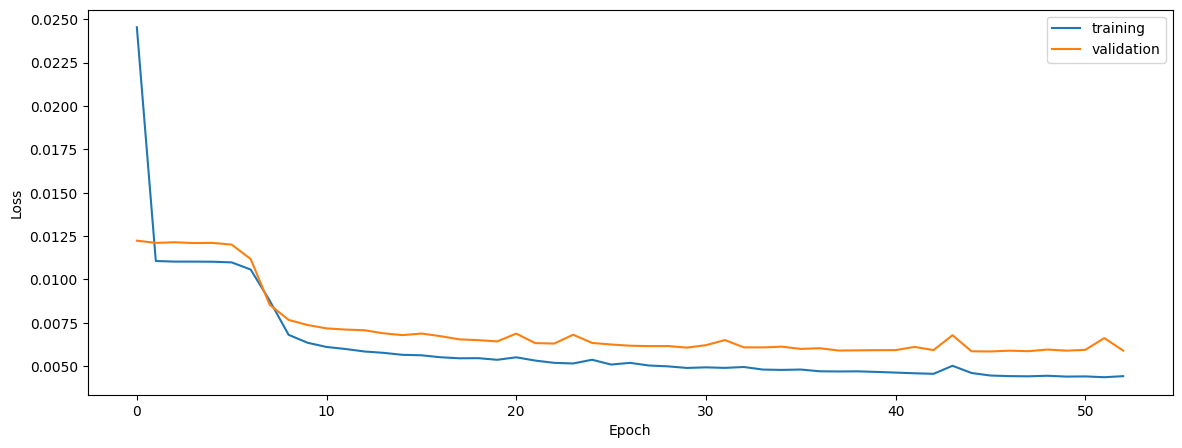

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7740644548000598
0.7205301949630648
0.7259841566358016


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7740644548000598
0.7205301949630648
0.7259841566358016


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.7888439299151884
0.733229066636006
0.7599612611930734


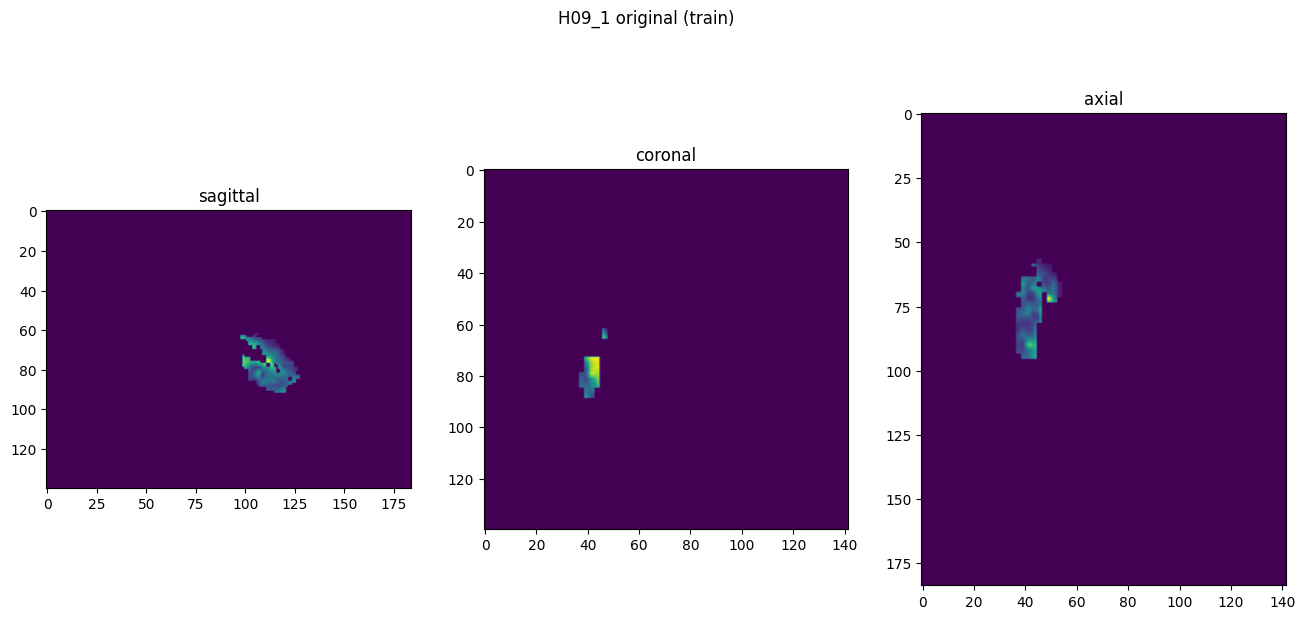

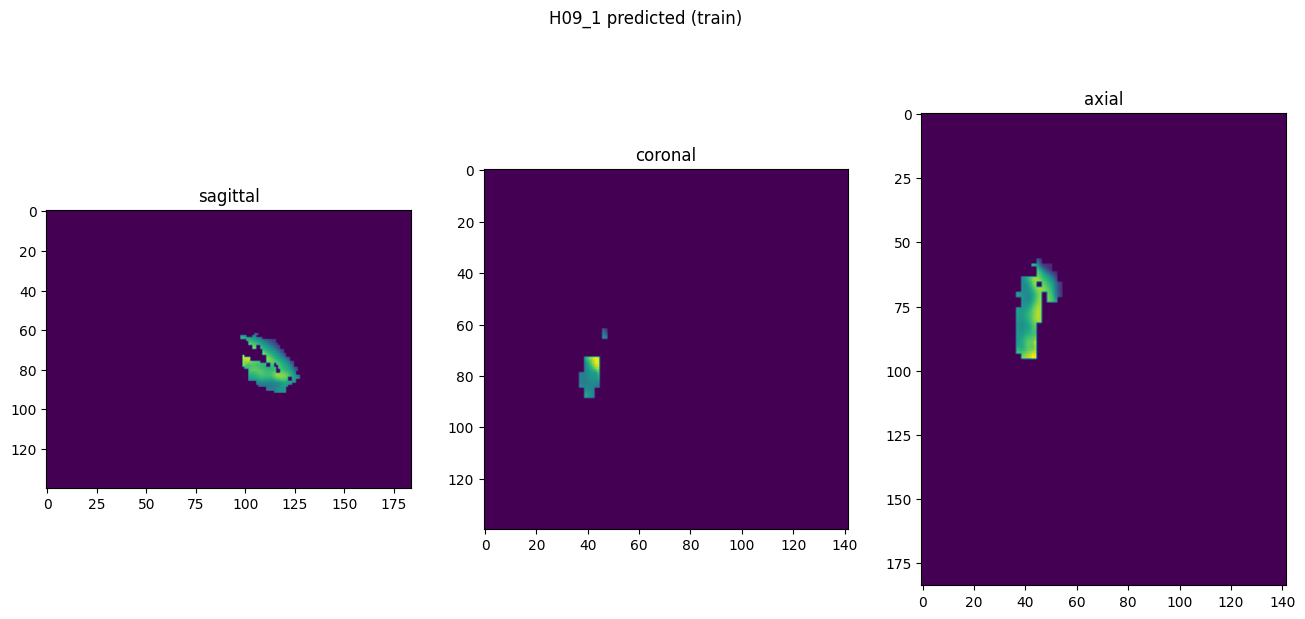

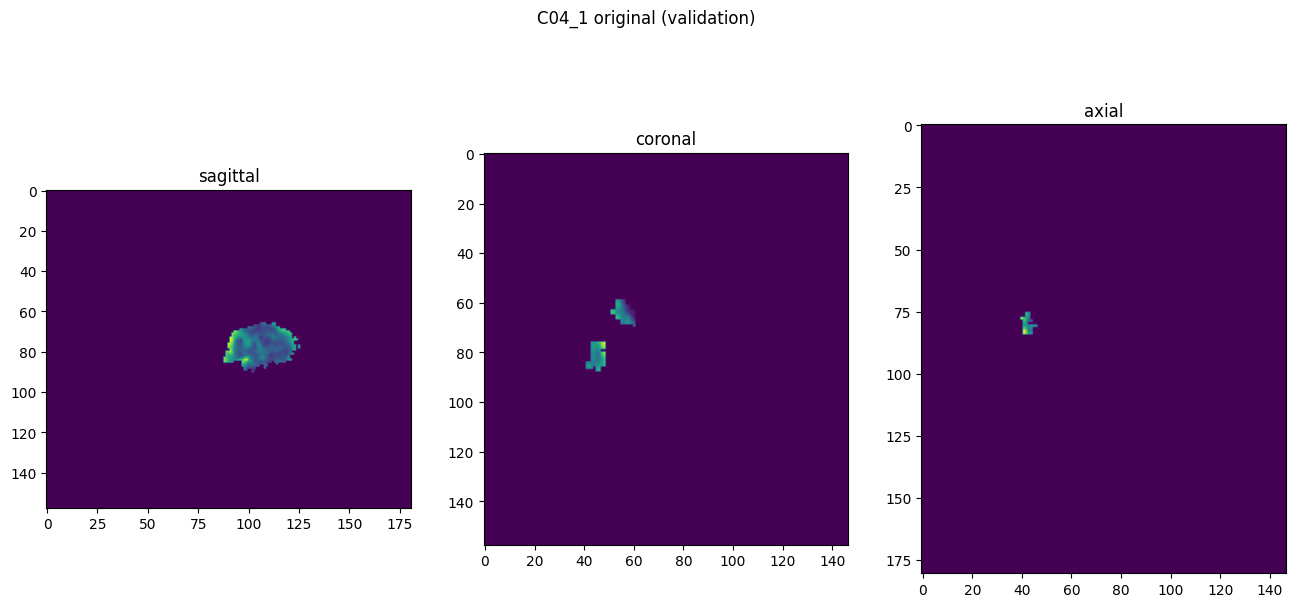

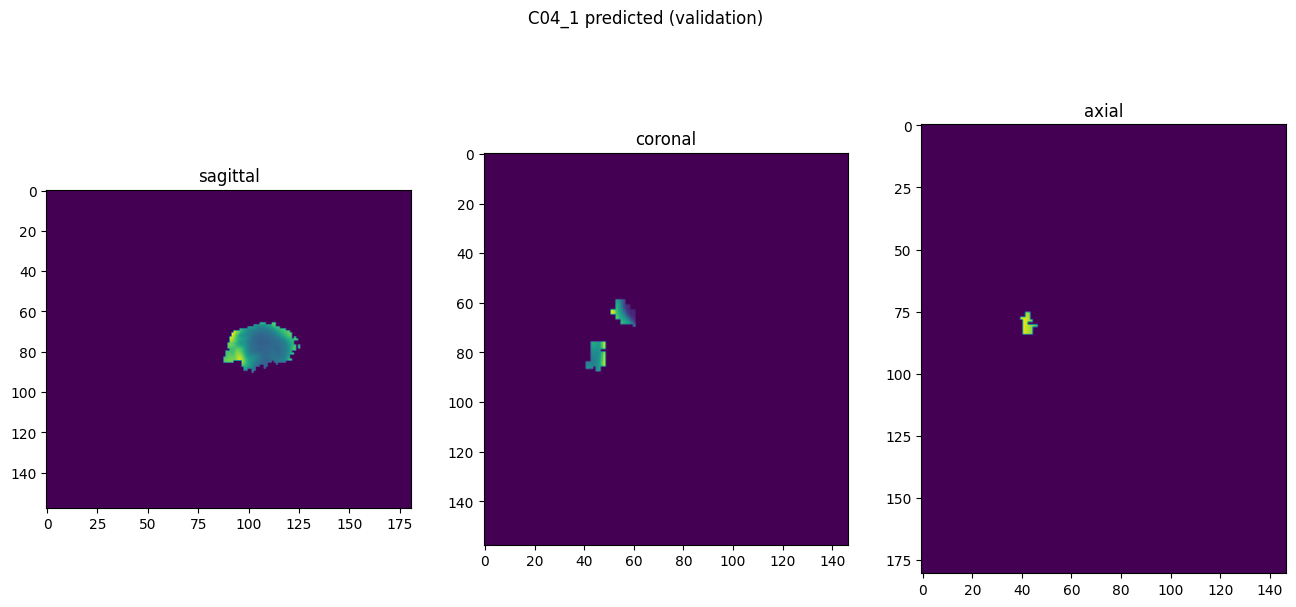

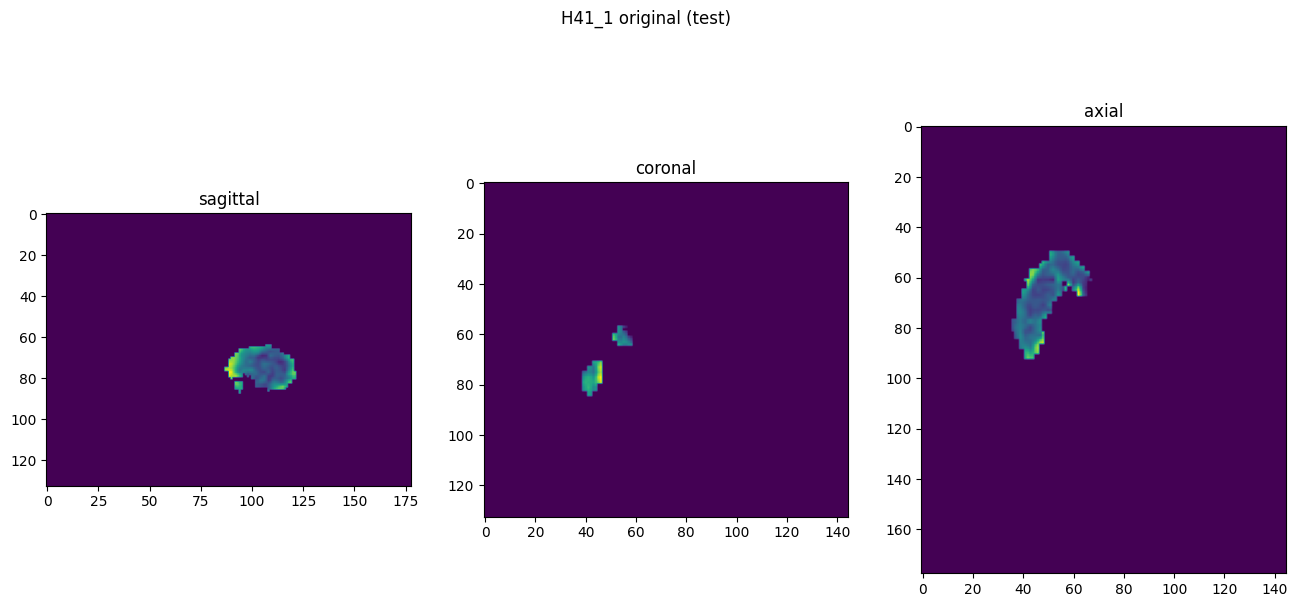

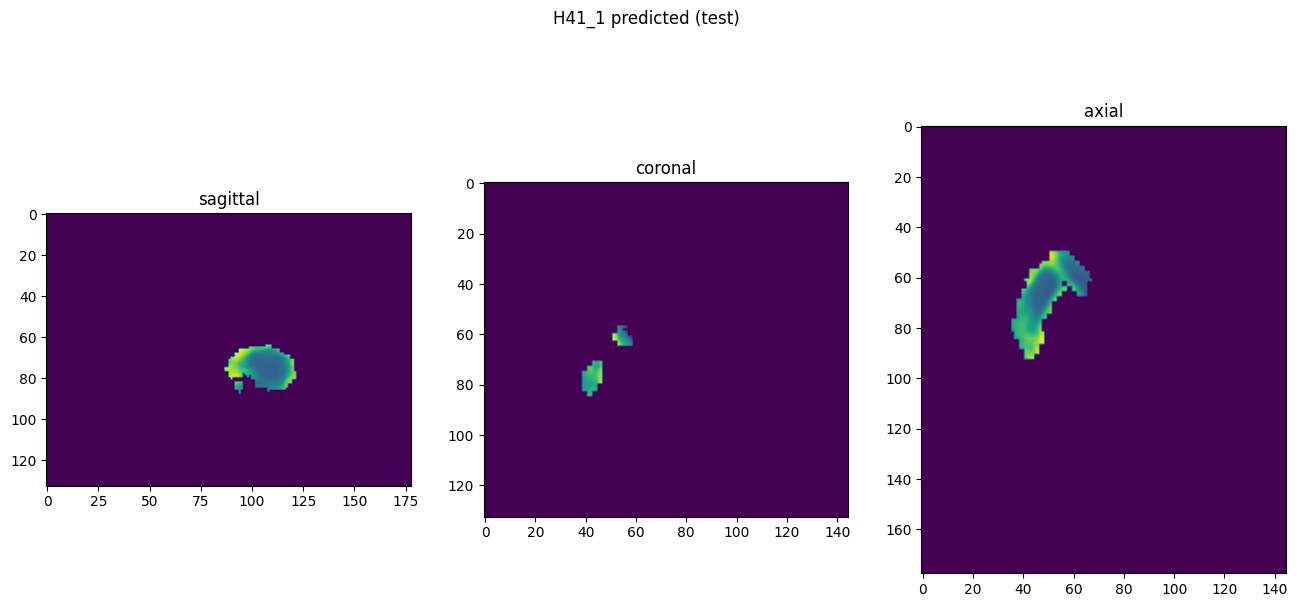

In [10]:
showResults(model, gen, threshold=None, background=False)